In [1]:
import os
import re
import json
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR_RAW = '/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/2010_relations_challenge'
DATA_DIR = r'/Users/chenkx/Box Sync/NLP group/2010 i2b2 challenge - rel'
MAP_DIR1 = "/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/simple_header_map.json"
MAP_DIR2 = "/Users/chenkx/Desktop/TBIC-not_synced/Sectionizer/data/section_mapping/sectionTypeMapping.json"

In [3]:
with open(MAP_DIR1, 'r') as f:
    section_map1 = json.load(f)
with open(MAP_DIR2, 'r') as f:
    section_map2_tmp = json.load(f)
section_map2 = {}
# reformat section_map2 to lower case
for i in section_map2_tmp:
    section_map2[i.lower()] = section_map2_tmp[i].lower()
del section_map2_tmp

In [4]:
filenames = [i[:-4] for i in os.listdir(os.path.join(\
    DATA_DIR, "train", "txt")) \
     if i.endswith(".txt")]

In [5]:
file = filenames[0]

In [6]:
with open(os.path.join(DATA_DIR, 'train', 'ref', file+'.ann'), 'r') as f:
    ann = f.readlines()

In [7]:
def std_header(phrase):
    """
    standardize heading from regex matches.
    First, use simple rules to check if a phrase is a header. Rules:
        1. A header does not contain digits.
    Then, normalize headings by:
        1. converting to lower case
        2. trim white space.
    """    
    if re.search('(^mg )|(^ml )|(^g )', phrase):
        return None
    
    phrase = re.sub(" :$", "", phrase.strip().lower())
    if phrase in section_map1:
        phrase = section_map1[phrase]
    if phrase in section_map2:
        phrase = section_map2[phrase]
    
    if phrase == '':
        return None
    
    return phrase

In [8]:
class Reader:
    def __init__(self, path, fname):
        """
        :param path - Path to the folder of which subfolders include "txt" and "ref"
        """

        self._path = path
        self.fname = fname
        
        self.ann = {}
        self._ann_raw = []
        self.all_headings = []
        
        with open(os.path.join(self._path, "txt", self.fname+".txt"), 'r') as f:
            self.txt = f.read()
        
    def get_all_headings(self):
        matches = re.finditer('[a-zA-Z ]+(( :\n)|( : ))', reader.txt)
        for m in matches:
            match = std_header(m.group(0))
            if match:
                b, e = m.span()
                self.all_headings.append( (match, b, e) )
#         self.all_headings = [std_header(match) for i, match in enumerate([re.search('[a-zA-Z ]+(( :$)|( : ))', txt) for txt in self.txt.split('\n')])]
    
    def get_annotation(self):
        """
        {
            fname: {
                iterm_id: {
                    b: int begin_offset, 
                    e: int end_offset, 
                    t: str "type",
                    a: str "assertion", 
                    c: str "concept_raw_text", 
                    s: str "section"
                }
                length: int length of the note 
            }
        }

        """
        fname = self.fname
        with open(os.path.join(self._path, "ref", fname+".ann"), 'r') as f:
            ann_raw = f.read().split('\n')
            self._ann_raw = ann_raw
        
        annotations = {}
        for line in ann_raw:
            line = line.split('\t')
            if line[0].startswith('T'):
                annotations[line[0]] = {
                    'b': int(line[1].split()[1]),  
                    'e': int(line[1].split()[2]), 
                    't': line[1].split()[0], 
                    'a': None, 
                    'c': line[2], 
                    's': None
                }
        for line in ann_raw:
            line = line.split('\t')
            if line[0].startswith('A'):
                if line[1].split()[1] not in annotations:
                    print(f"Warning: {line[0]} ??")
                annotations[line[1].split()[1]]['a'] = line[1].split()[0]
                
        # remove annotations that don't have assertion informaiton 
        delete = []
        for i in annotations:
            if annotations[i]['a'] is None:
                delete.append(i)
        for i in delete:
            del annotations[i]
        
        annotations['length'] = len(self.txt)
        
        self.ann = {fname: annotations}    

### Pareto chart of section types
Find the top n section types that make up 80% of occurrences.

In [9]:
all_headings = []
for file in filenames:
    reader = Reader(os.path.join(DATA_DIR, "train"), file)
    reader.get_all_headings()
    all_headings.extend([i[0] for i in reader.all_headings])

In [11]:
len(set(all_headings))

865

In [12]:
# Save to disk 
# with open('header_map.json', 'w') as f:
#     for i in sorted(list(set(all_headings))):
#         f.writelines(i + '::' + i + '\n')    

In [13]:
# count the occurances of each section type
heading_count = {}
for i in all_headings:
    if not i:
        continue
    if i not in heading_count:
        heading_count[i] = 0
    heading_count[i] +=1

In [14]:
# remove types that only occur once. Prepare data for plotting
data = sorted(list(heading_count.items()), key=lambda x: -x[1])
for i, e in enumerate(data):
    if e[1] == 1:
        idx = i
        break
data = data[:idx]
section = [x for x, y in data]
cnt = [y for x, y in data]
cumsum = [0]
for i in cnt:
    cumsum.append(cumsum[-1]+i)
cumsum.pop(0)

0

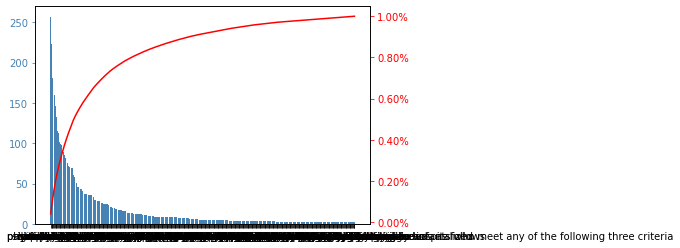

In [15]:
from matplotlib.ticker import PercentFormatter

#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(section, cnt, color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(section, [i/sum(cnt) for i in cumsum], color=color2, ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

In [16]:
# keep only the top n section types that make up 80% of all occurrences
n = len([i for i in cumsum if i/sum(cnt) < .8])
data = data[:n+1]
section = section[:n+1]
cnt = cnt[:n+1]

In [19]:
common_sections = section
common_sections[:30]

['medications',
 'date',
 'd',
 't',
 'discharge date',
 'diagnoses',
 'dictated by',
 'hospital course',
 'present illness',
 'past medical history',
 'sex',
 'allergies',
 'physical examination',
 'report status',
 'r',
 'disposition',
 'patient name',
 'service',
 'job id',
 'social history',
 'dictator',
 'mrn',
 'abdomen',
 'date of birth',
 'labs',
 'signed electronically by',
 'attending physician',
 'age',
 'attending',
 'family history']

In [18]:
len(common_sections)

101

### Distribution of Contextual information
Fist make sure only concepts whose type is "problem" have assertion info. 
Then show the disctribution of the 6 types of assertion.
Lastly, show the distribution of assertion by section type. Note that only a few section types are selected here. 

In [569]:
all_annot = {}
for file in filenames:
    reader = Reader(os.path.join(DATA_DIR, "train"), file)
    reader.get_annotation()
    if not reader.ann:
        print(f'{file} does not contain assertion annotations')
        continue
    all_annot = {**all_annot, **reader.ann}
    

In [570]:
# only concepts of "problem" have annotation of its assertion status
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length': 
            continue
        if annot[i]['t'] != 'problem':
            print(f'{f}: {annot[i]["c"]}')

In [571]:
ast = []
loc = []
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length':
            continue
        ast.append(annot[i]['a'])
        loc.append(annot[i]['b']/annot['length'])

In [572]:
df = pd.DataFrame({'ast': ast, 'loc': loc})

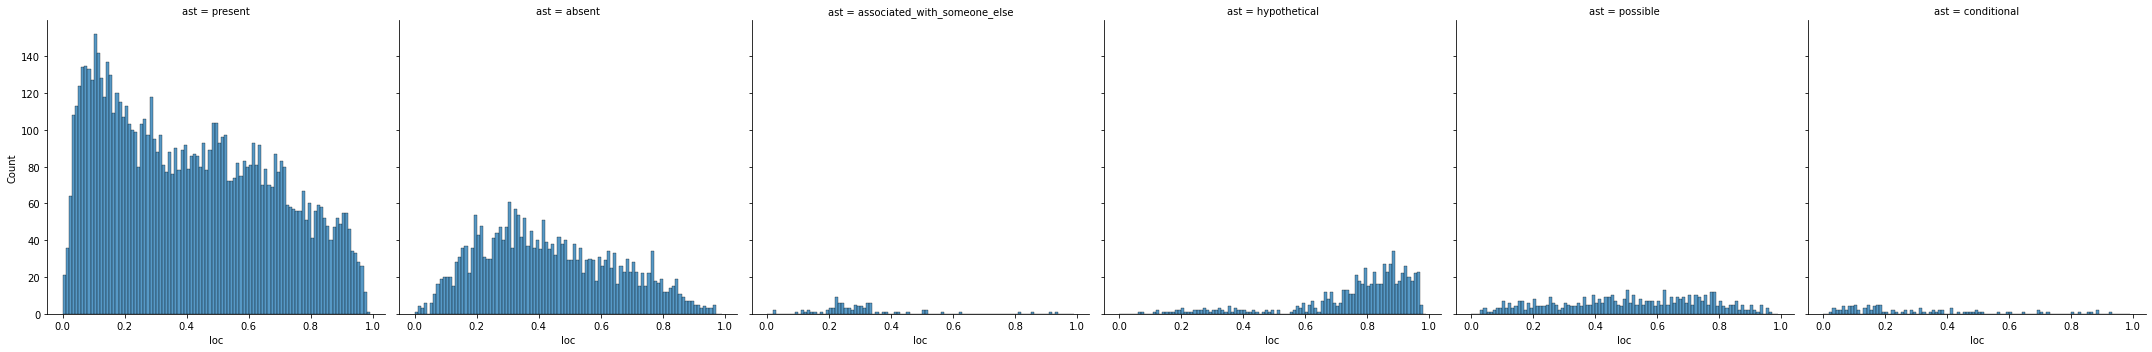

In [645]:
# distribution of negations
import seaborn as sns
sns.displot(df, x='loc', binwidth=.01, col='ast')

In [579]:
for f in all_annot:
    reader = Reader(os.path.join(DATA_DIR, "train"), f)
    reader.get_all_headings()
    h_left = [i[1] for i in reader.all_headings]
    for i in all_annot[f]:
        if i == 'length':
            continue
        annotation = all_annot[f][i]

        s_i = bisect.bisect_left(h_left, all_annot[f][i]['b']) - 1 
        if s_i == -1:
            section = 'other'
        else:
            section = [i[0] for i in reader.all_headings][s_i]
        all_annot[f][i]['s'] = section

In [580]:
sections = []
for f in all_annot:
    annot = all_annot[f]
    for i in annot:
        if i == 'length':
            continue
        sections.append(annot[i]['s'])

In [581]:
df['sections'] = sections

In [586]:
df[:3]

,ast,loc,sections
0,present,0.032919,problem list
1,present,0.043160,problem list
2,present,0.051390,problem list


medications


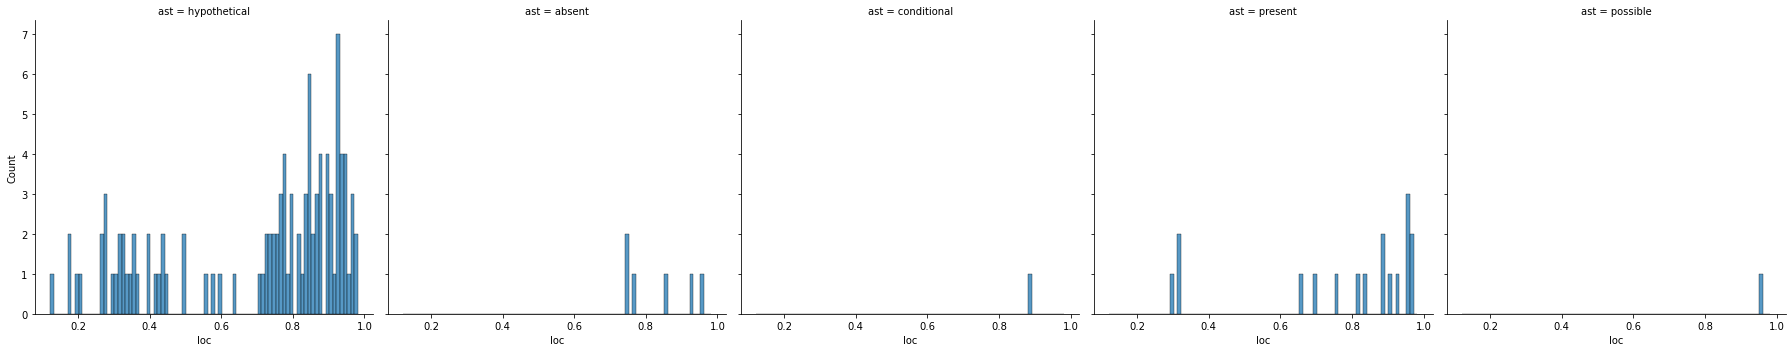

discharge date


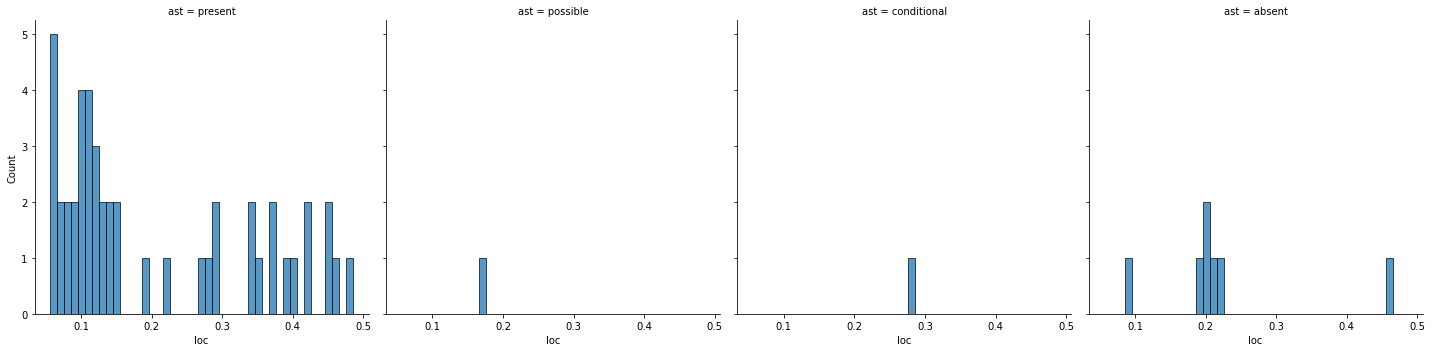

diagnoses


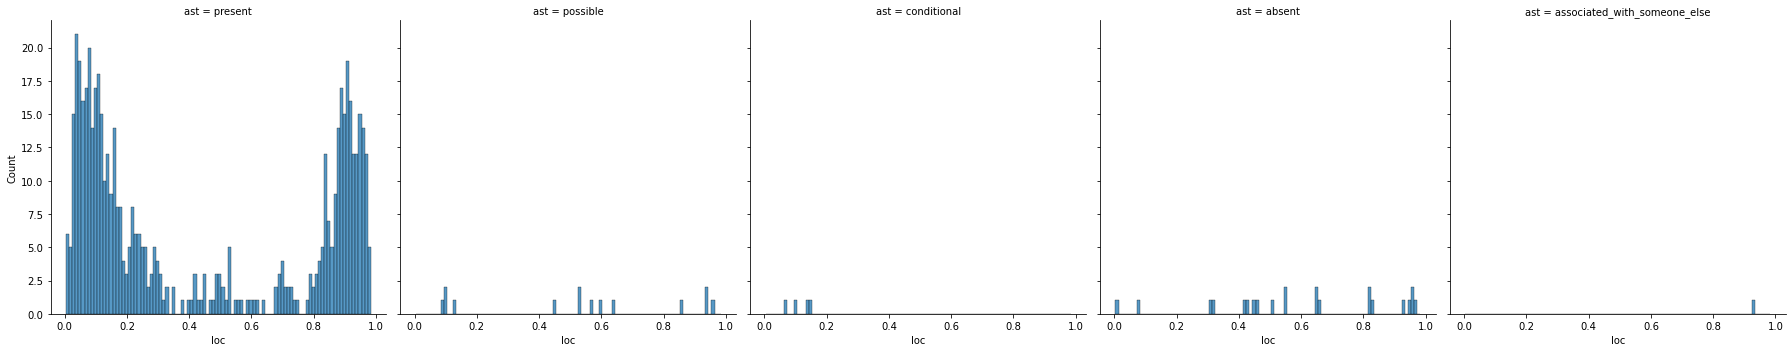

hospital course


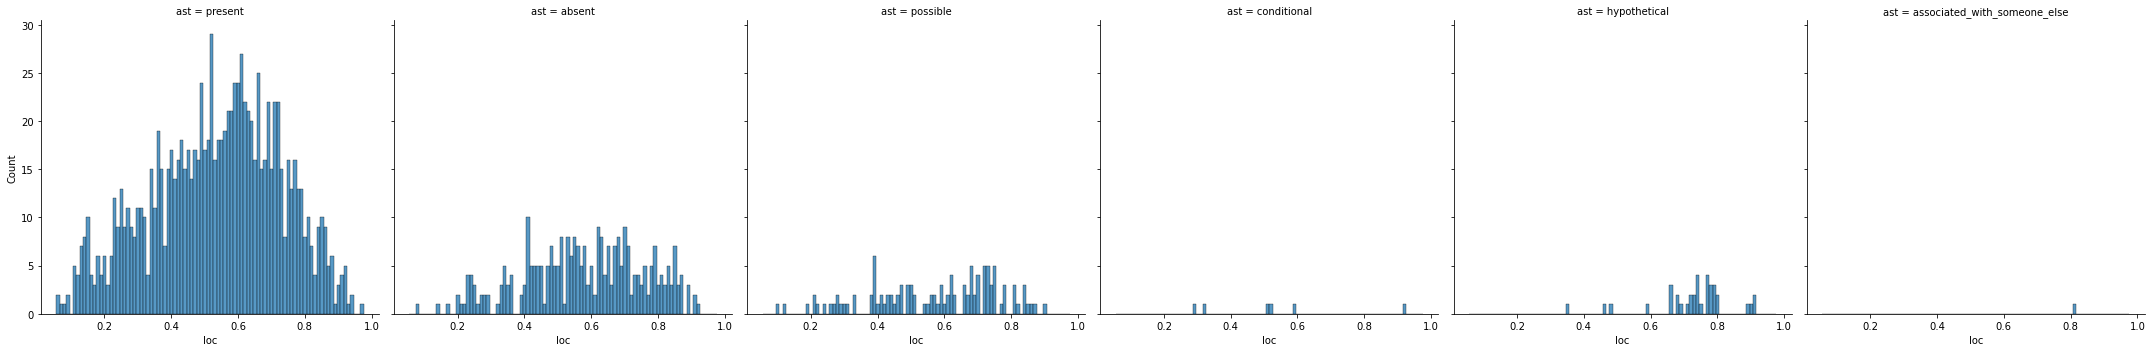

present illness


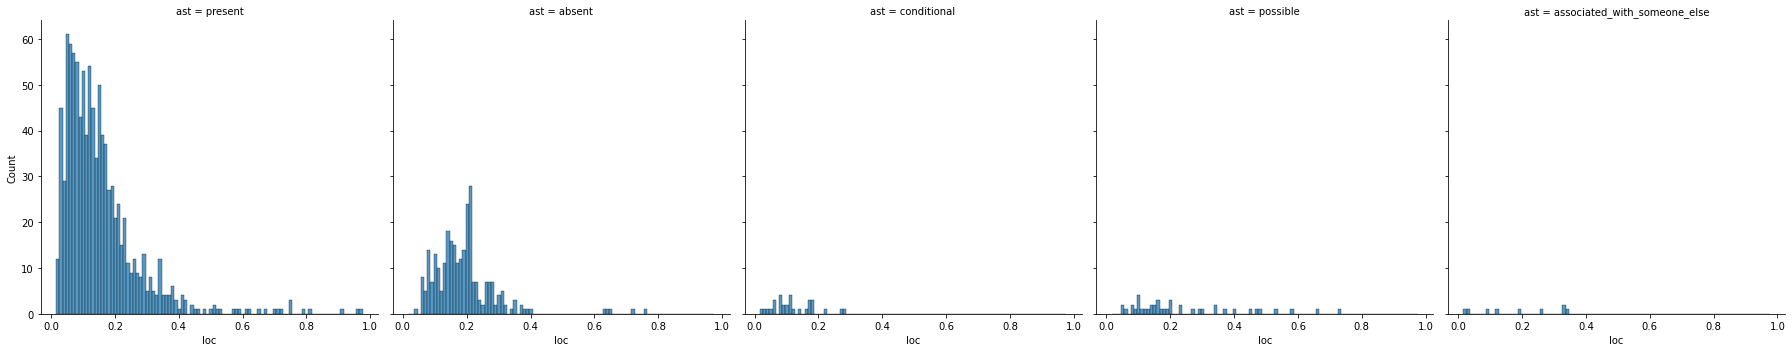

past medical history


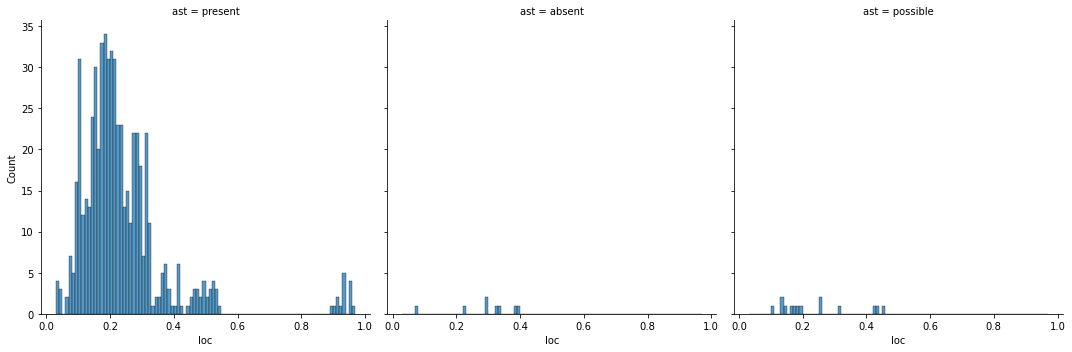

allergies


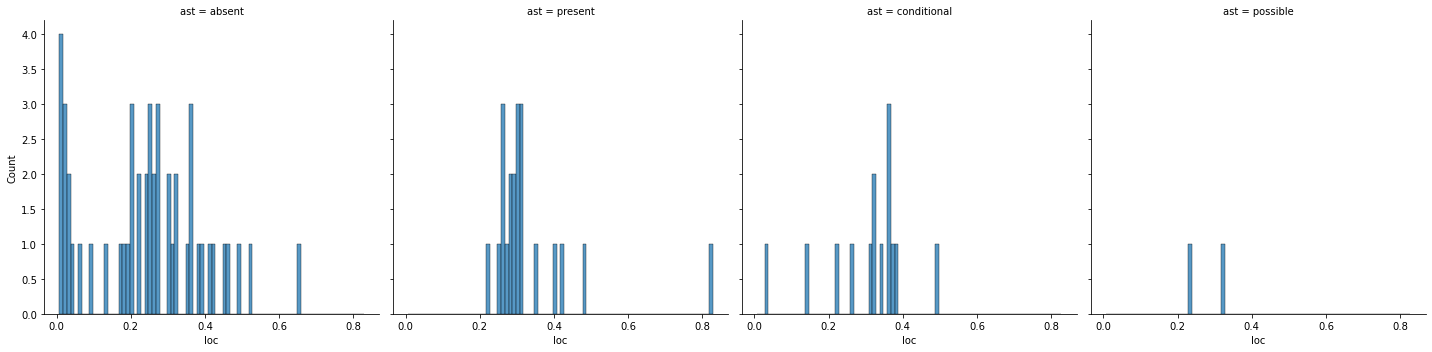

physical examination


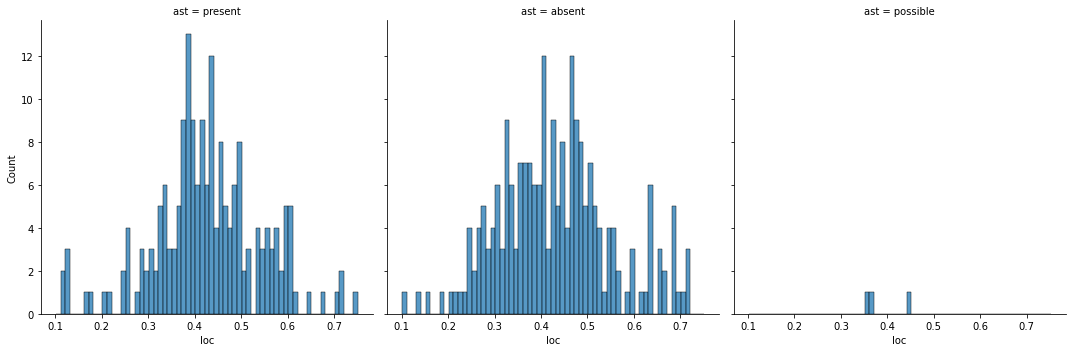

disposition


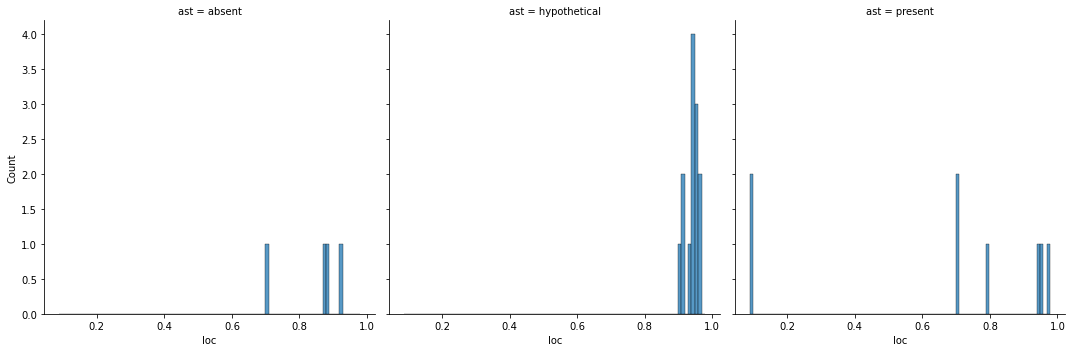

service


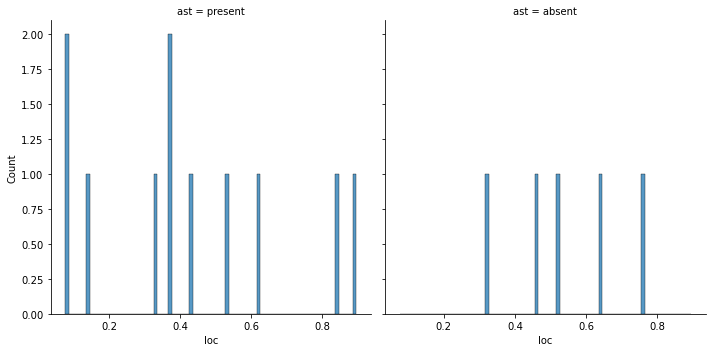

social history


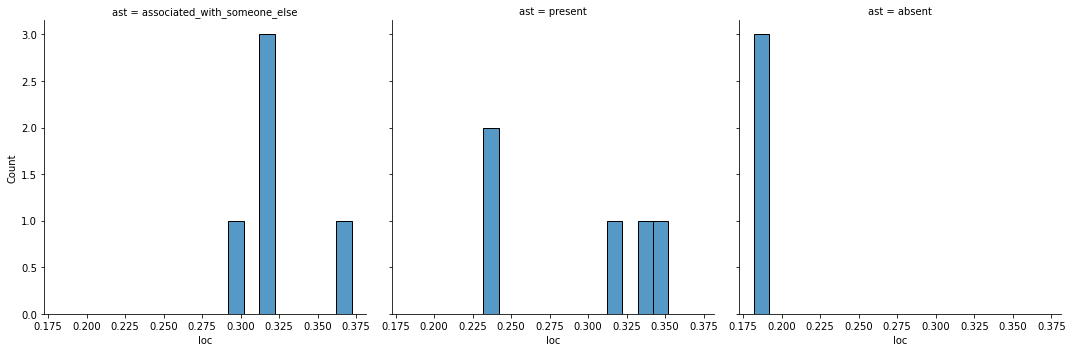

abdomen


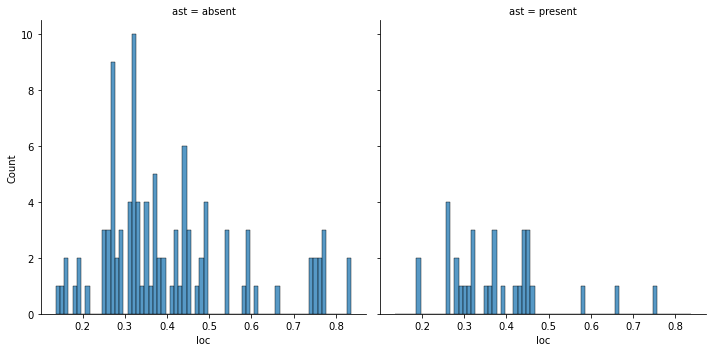

labs


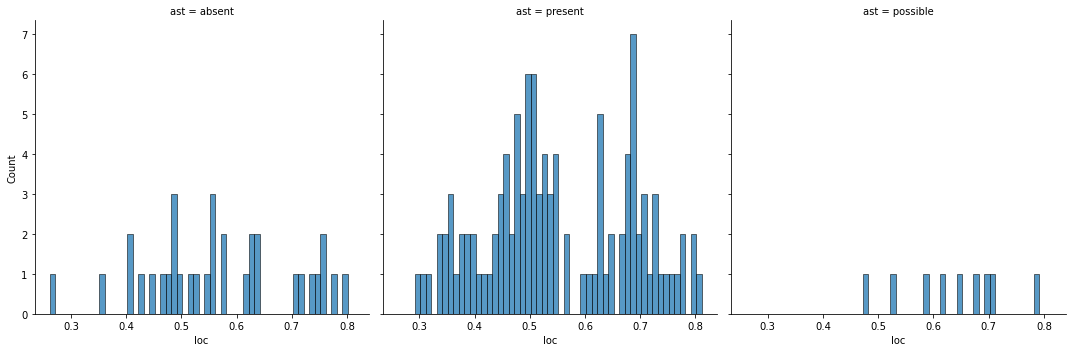

attending


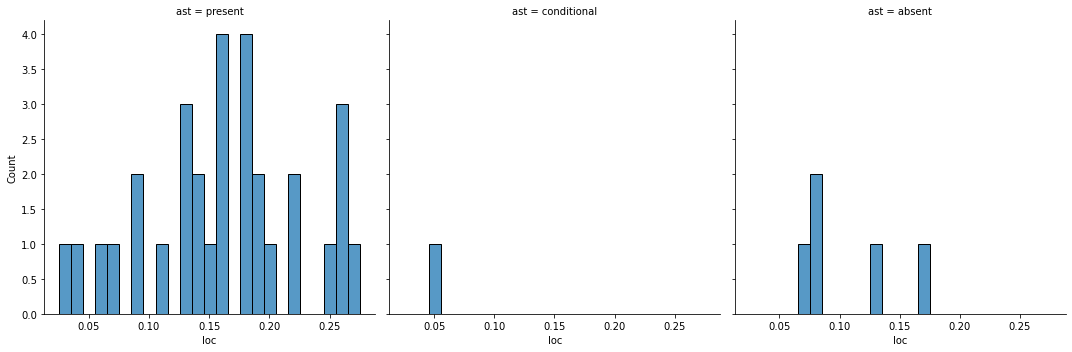

family history


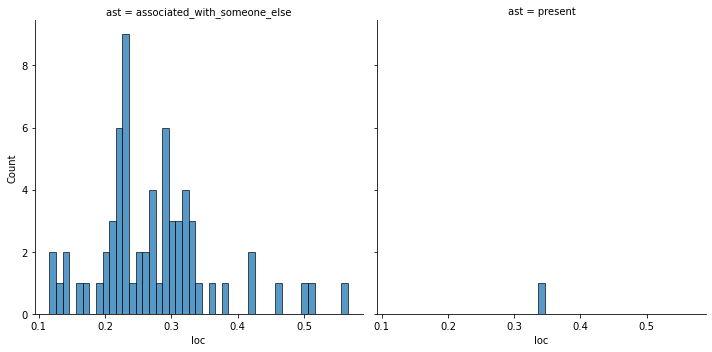

discharge instructions


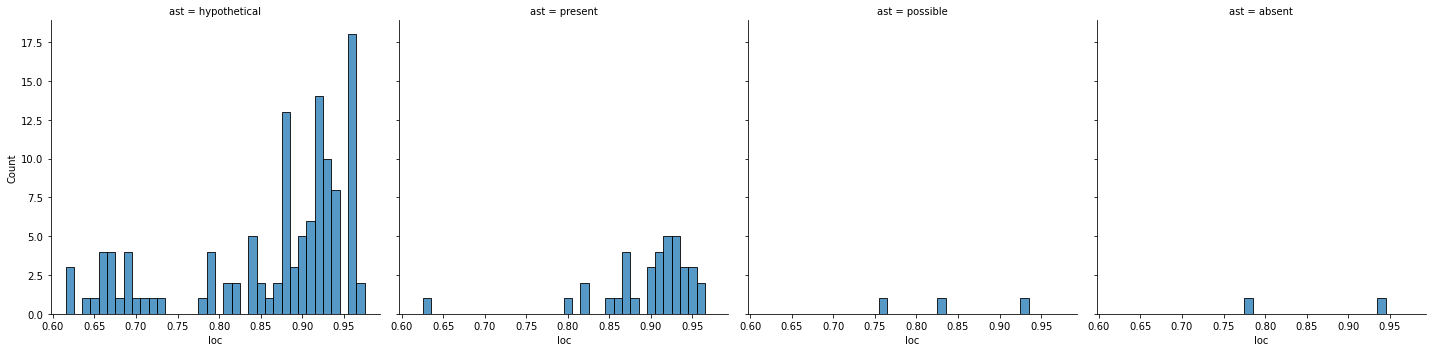

discharge condition


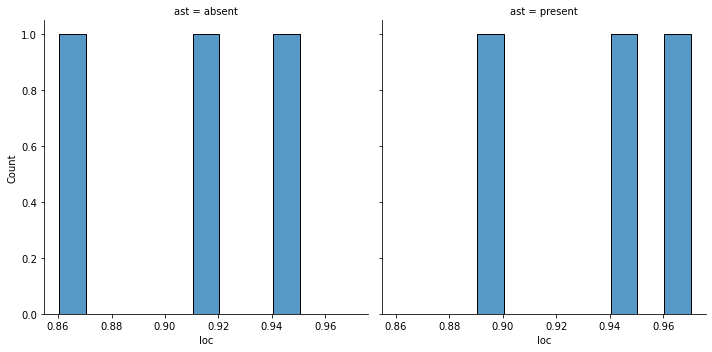

lungs


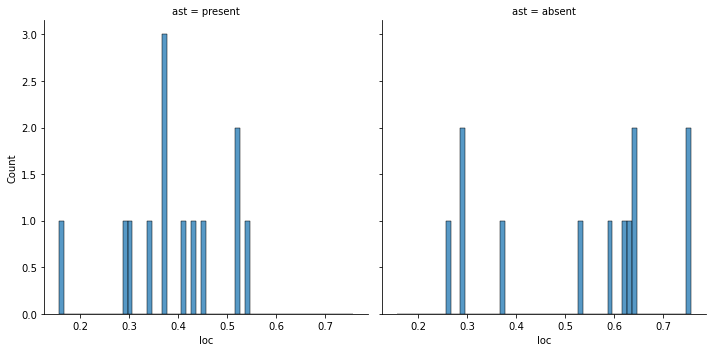

evaluation date


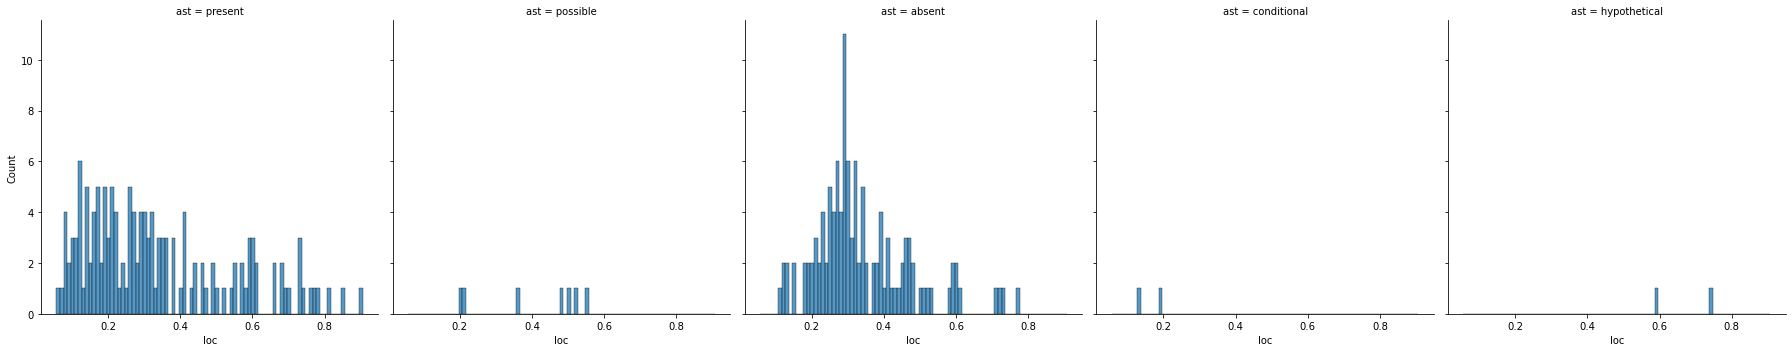

drug form


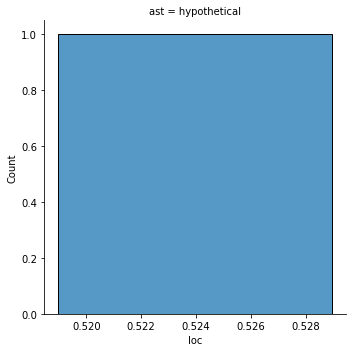

vitals


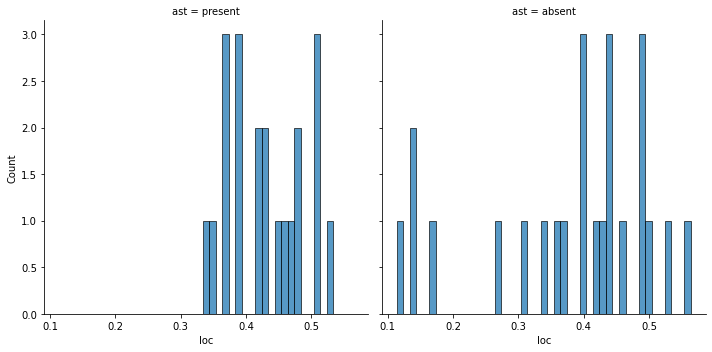

follow up


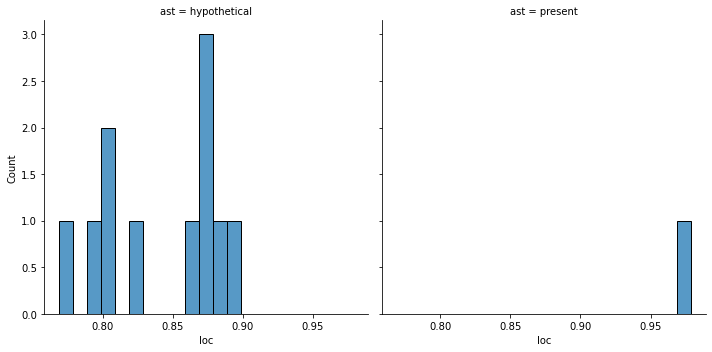

condition on discharge


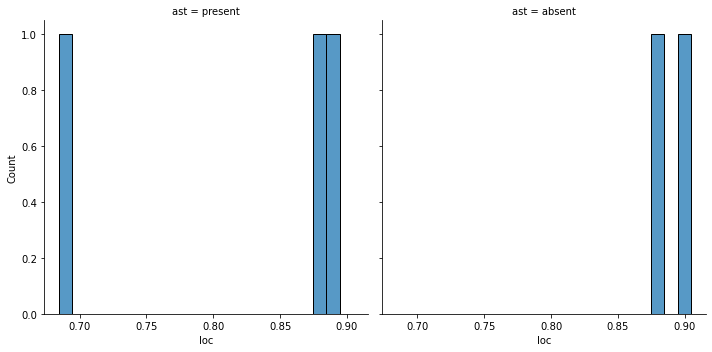

cc


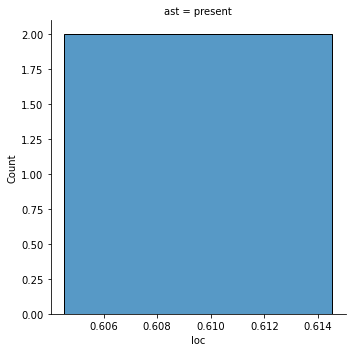

chief complaint


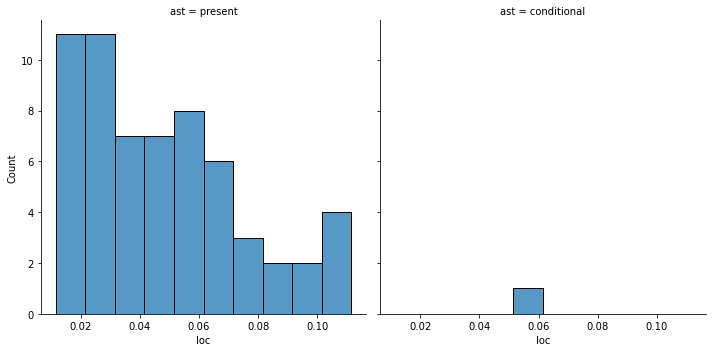

extremities


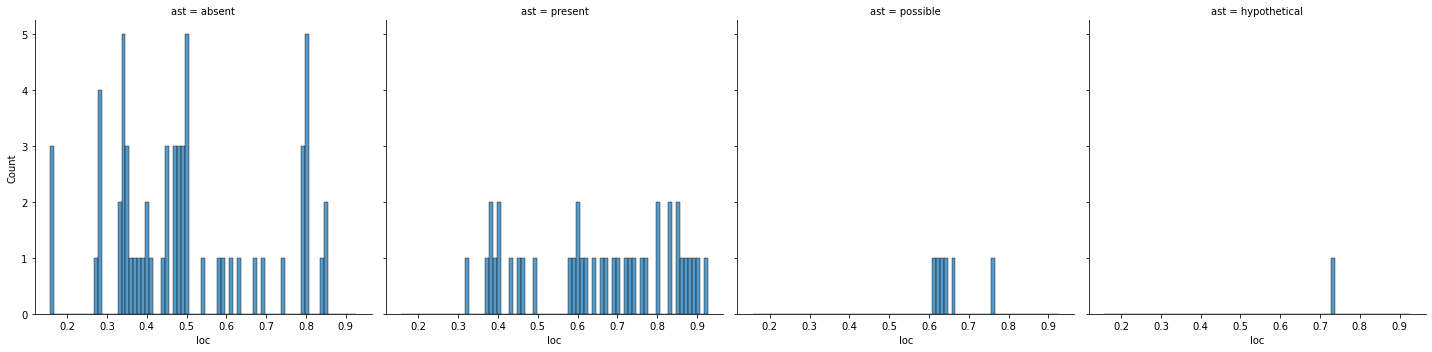

heent


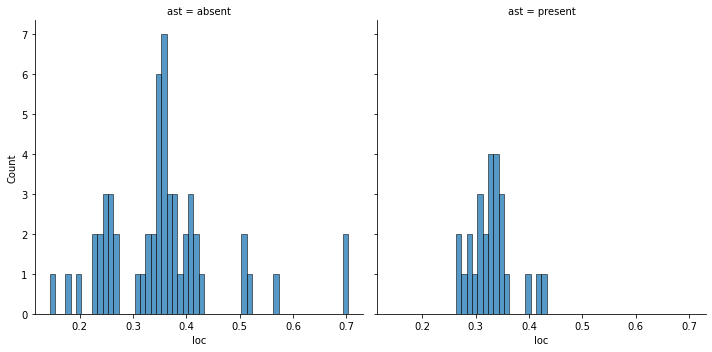

heart


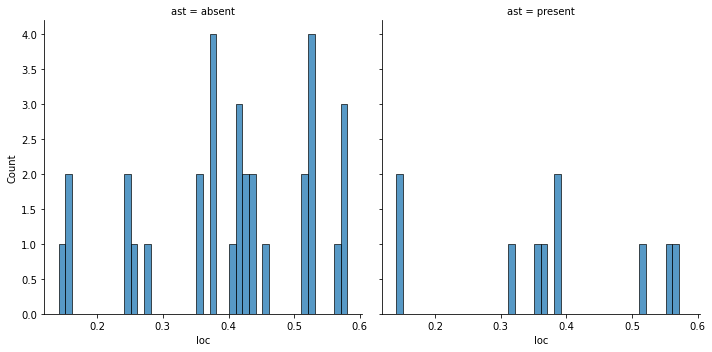

attend


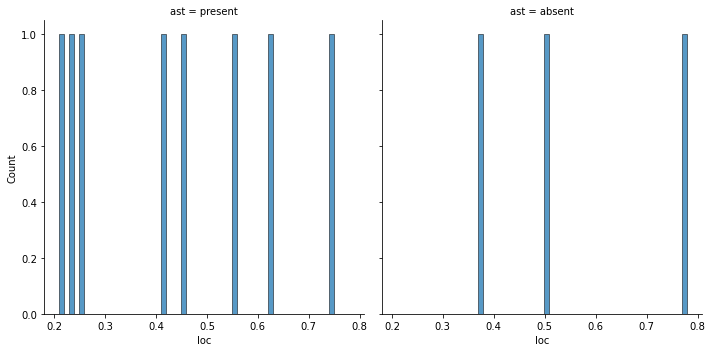

author


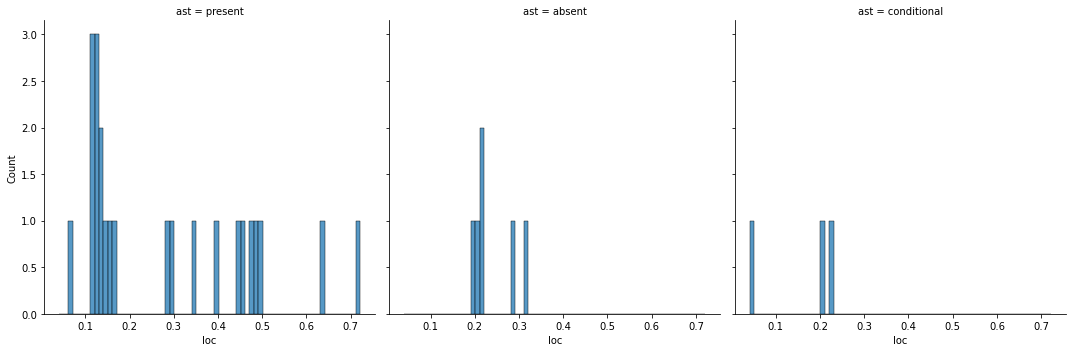

principal diagnosis


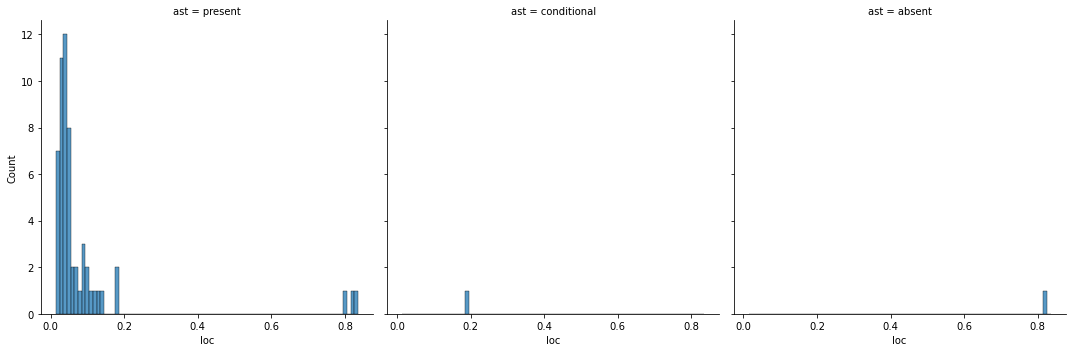

registration date


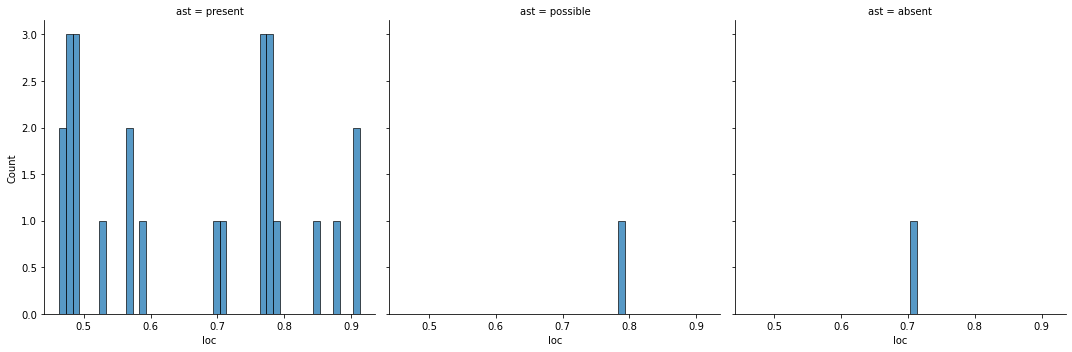

physical exam


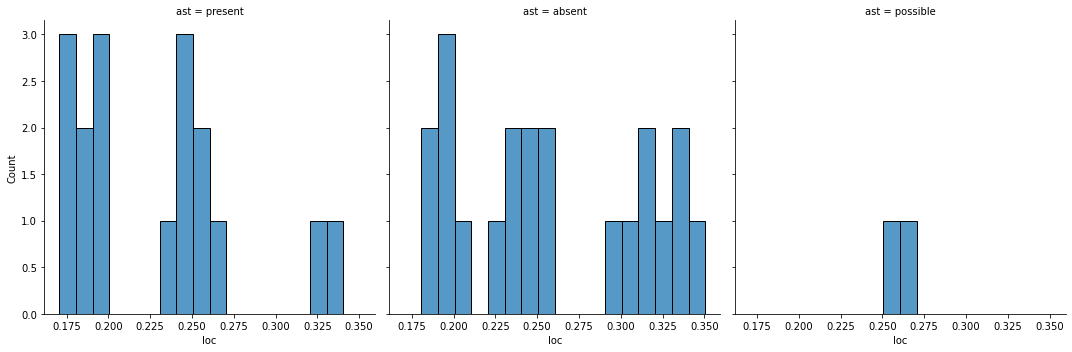

impression


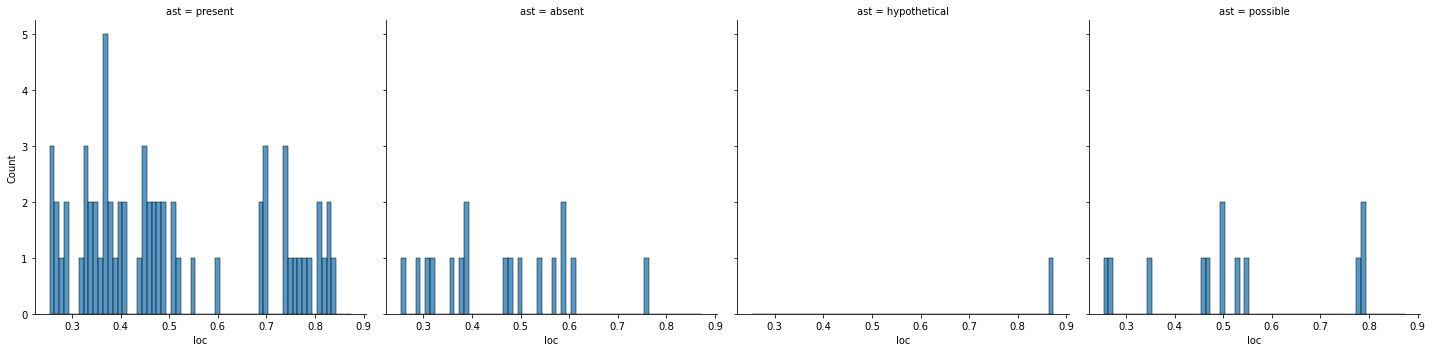

surgical procedure


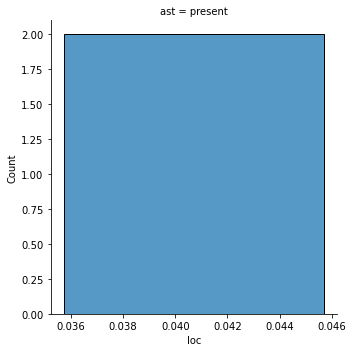

cardiovascular


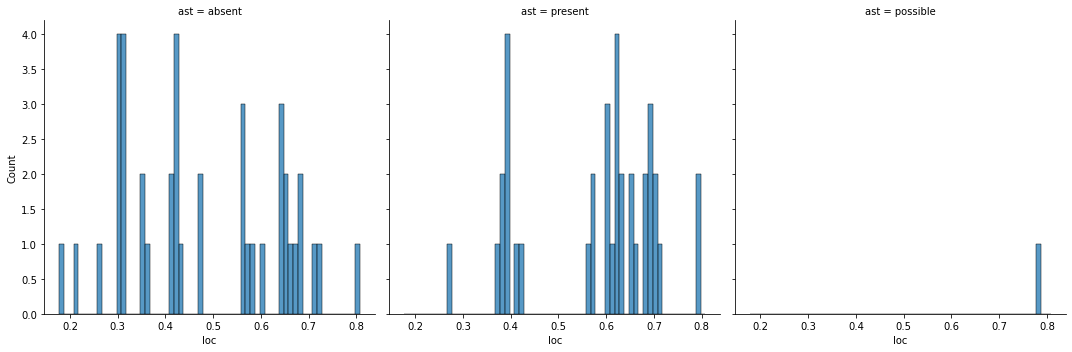

neck


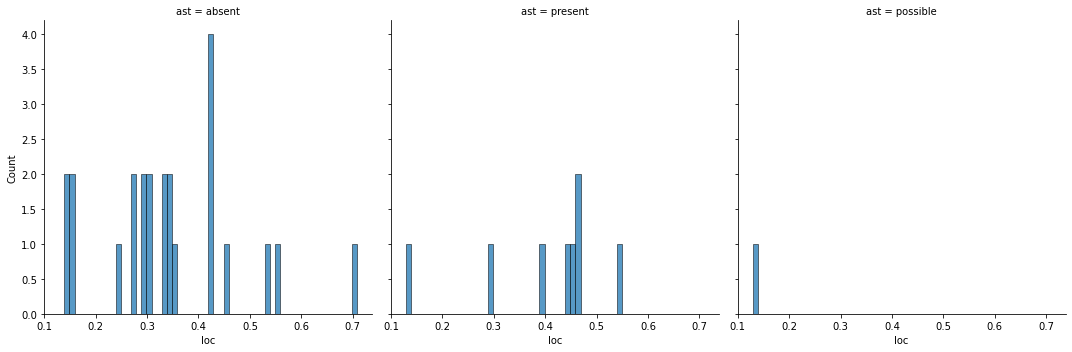

brief hospital course


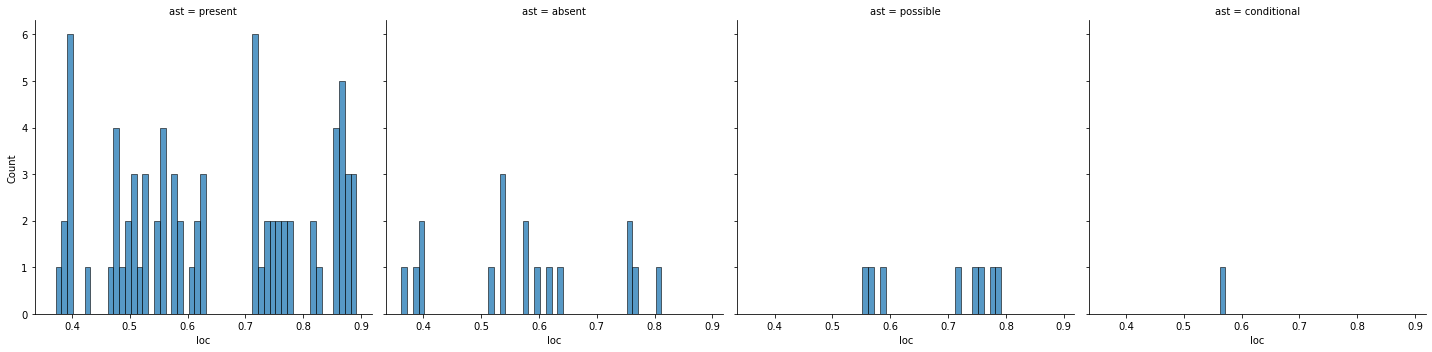

sig


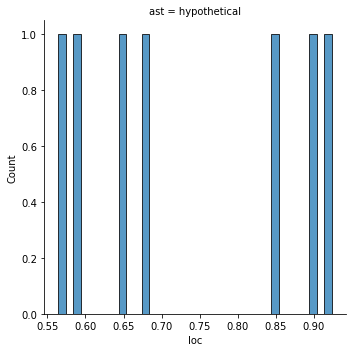

diet


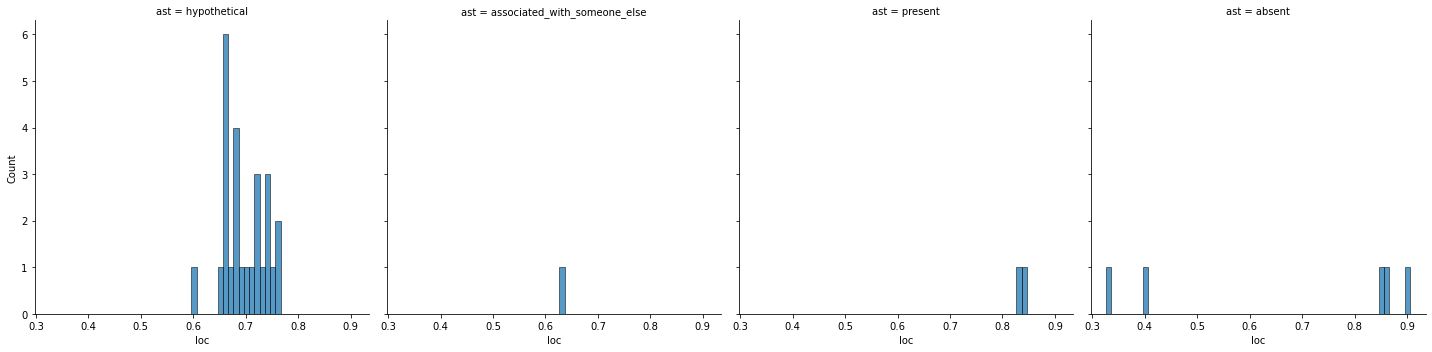

activity


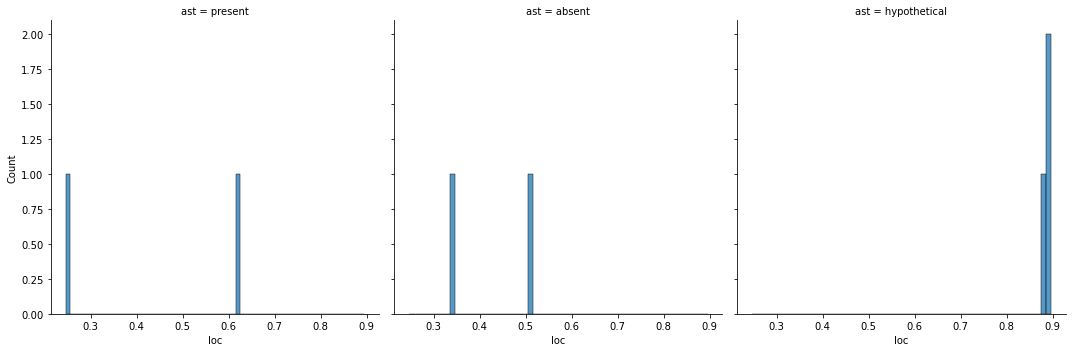

pertinent results


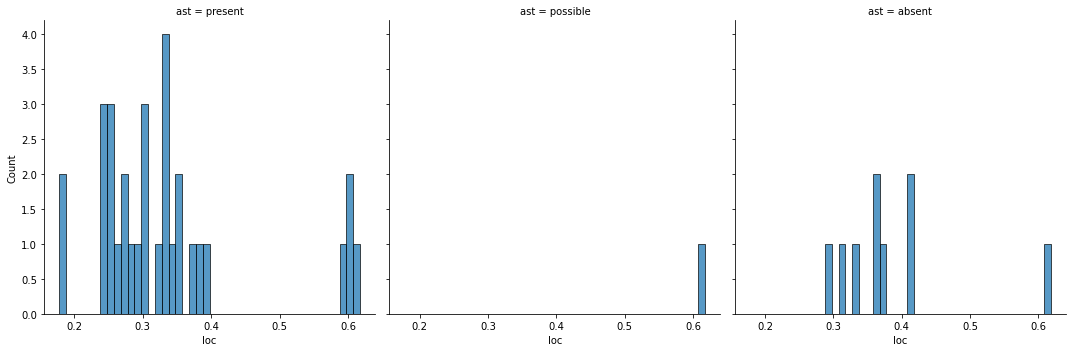

ext


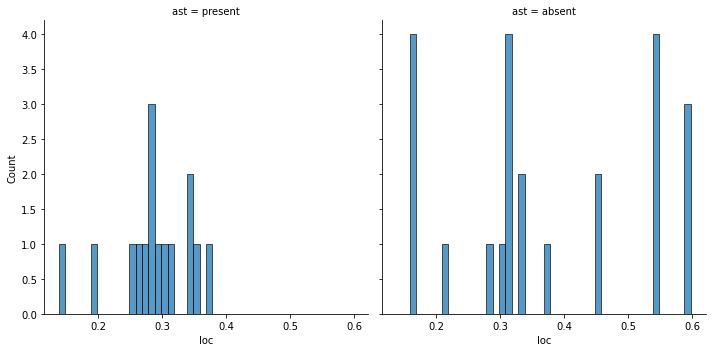

general


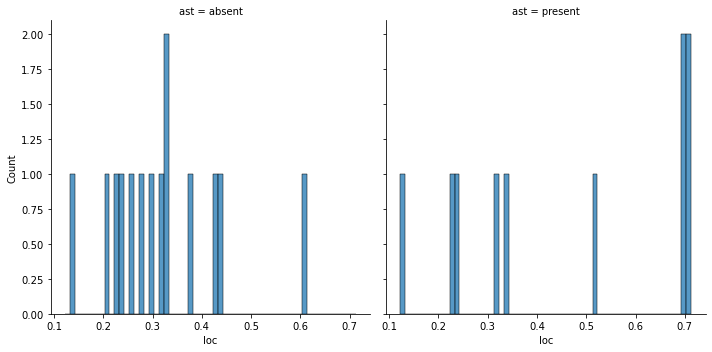

neurology


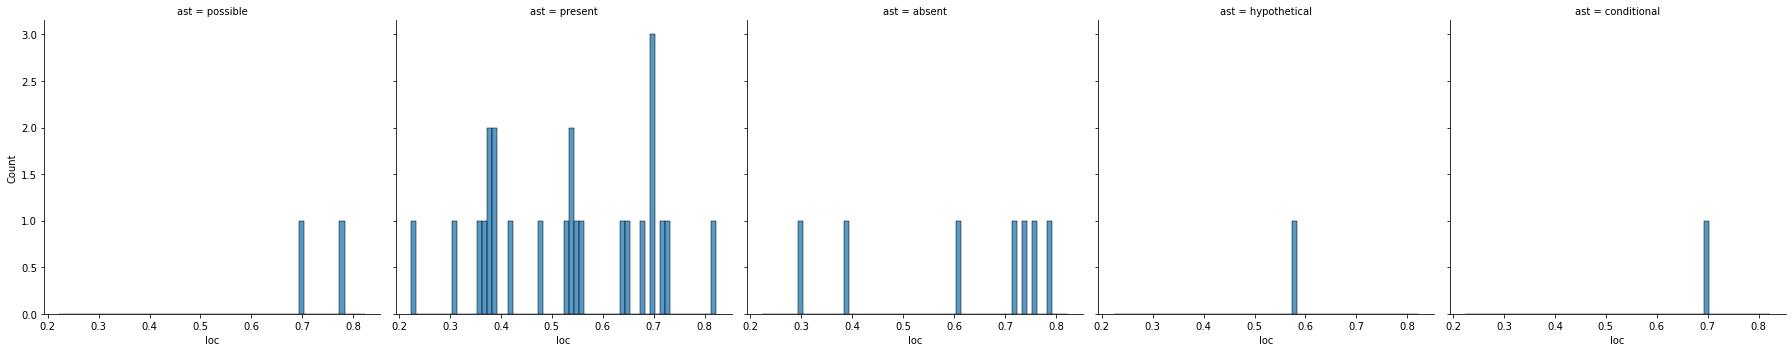

neuro


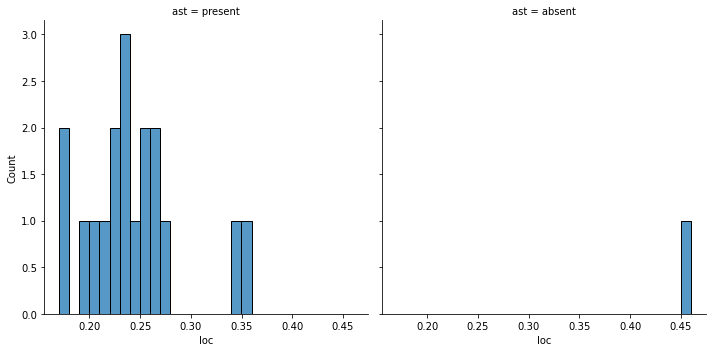

gen


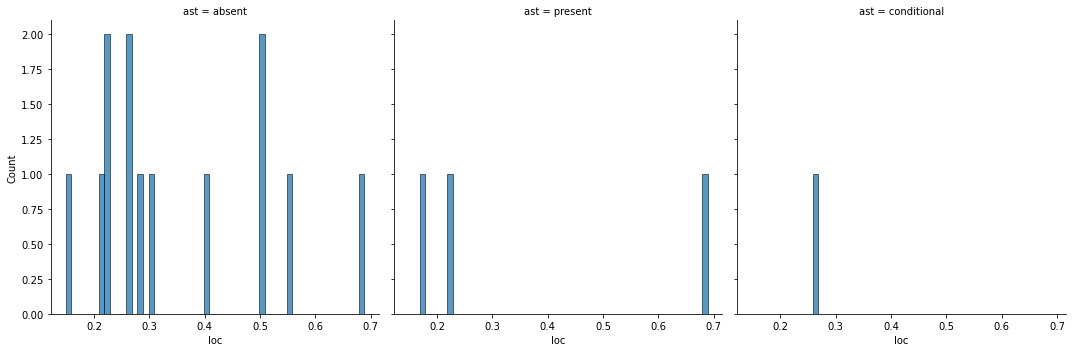

review of systems


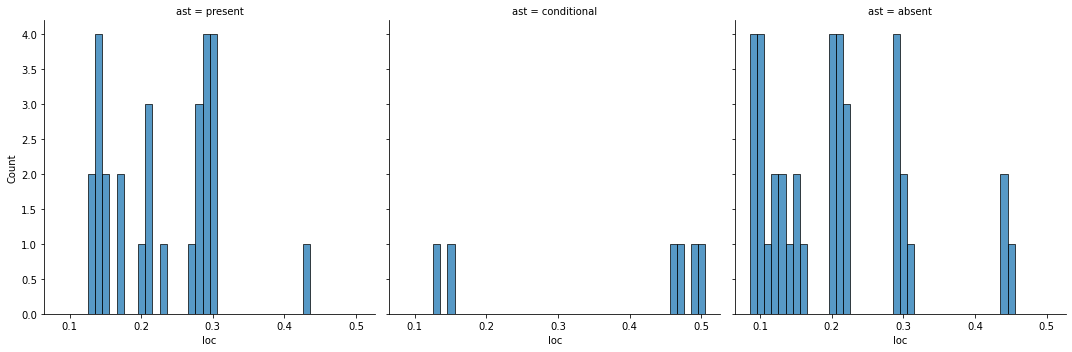

cv


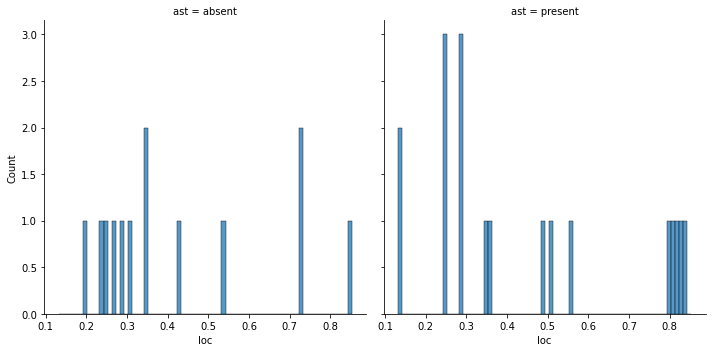

patient states complaint


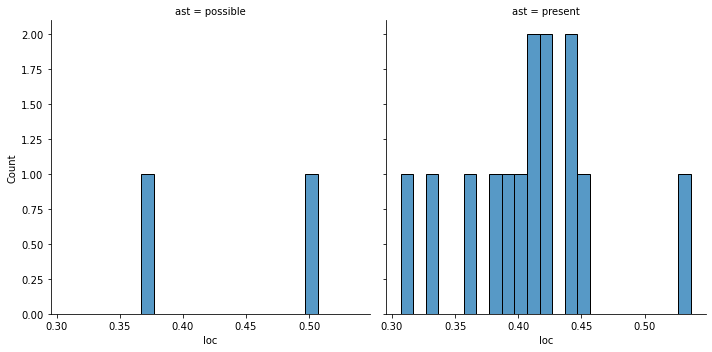

follow up and instructions to patient


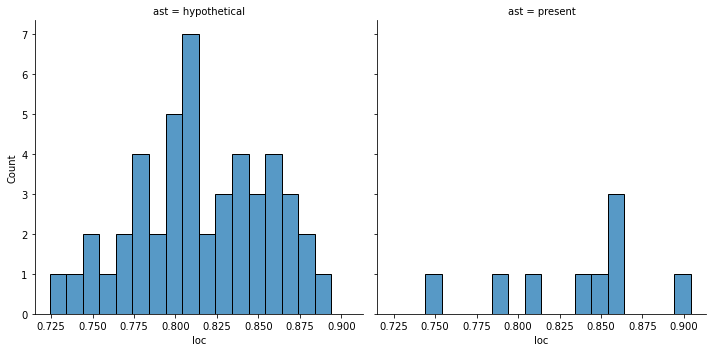

gastrointestinal


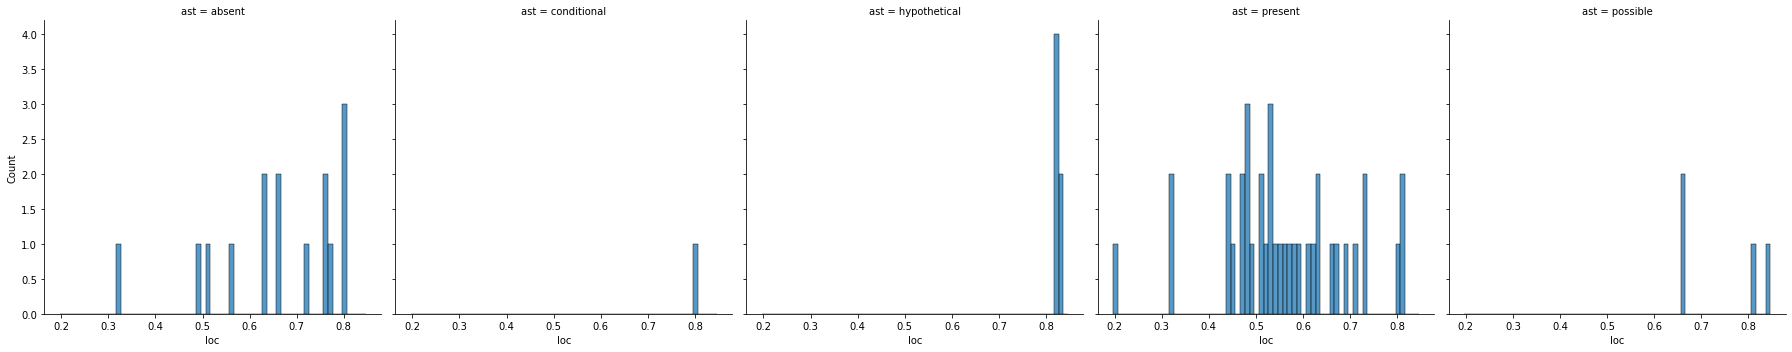

skin


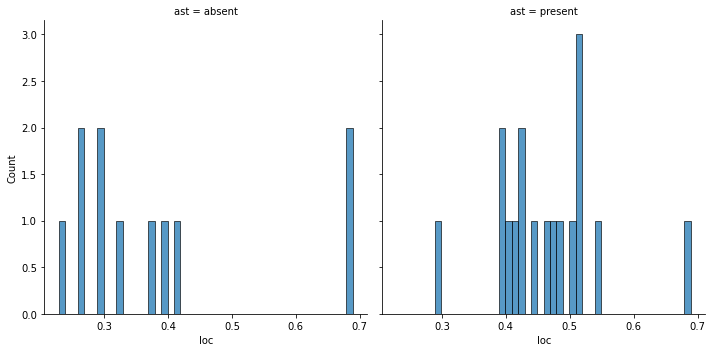

assessment and plan


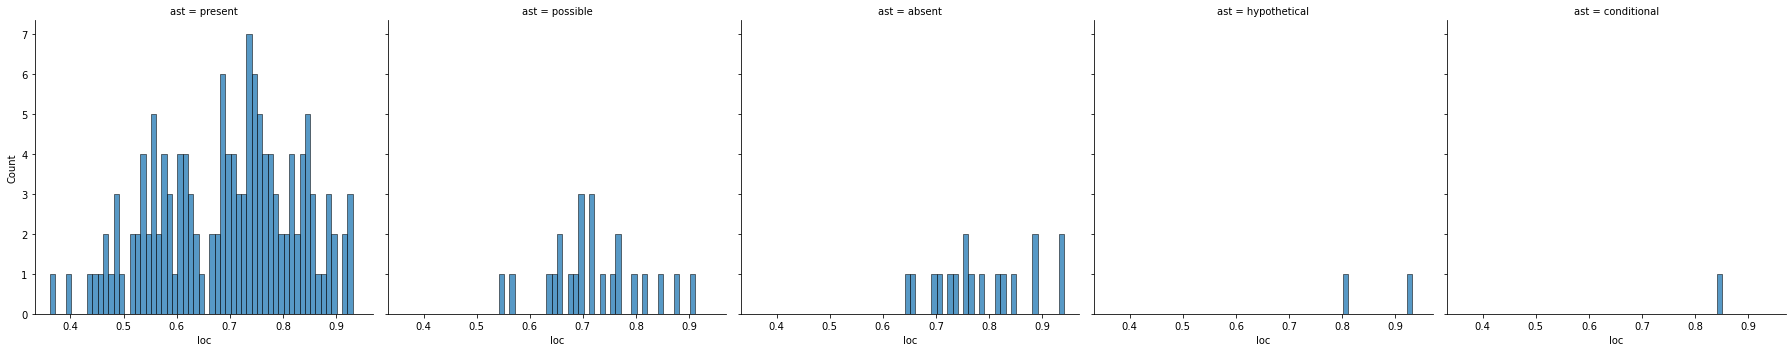

treatment rendered


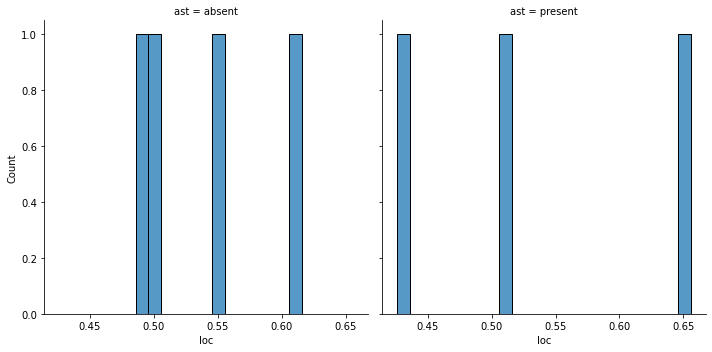

reason for admission


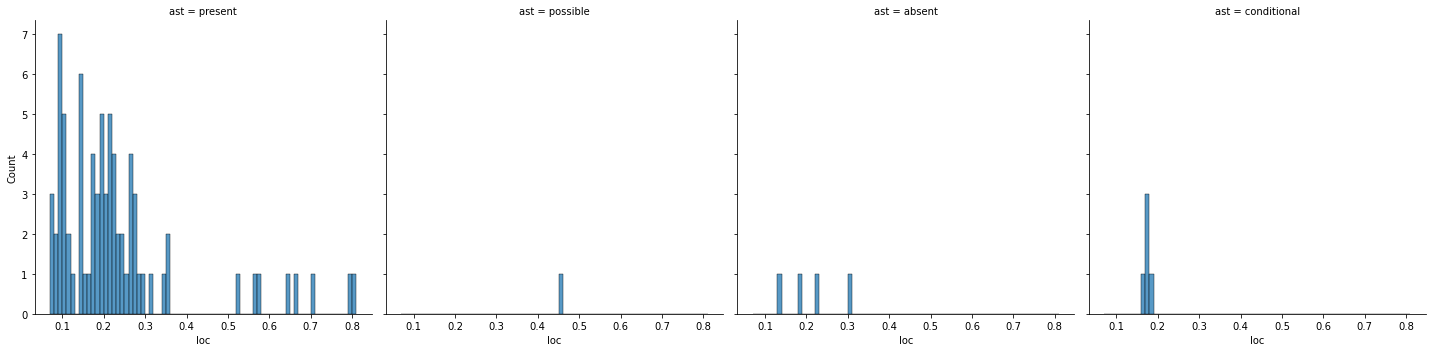

assessment/plan


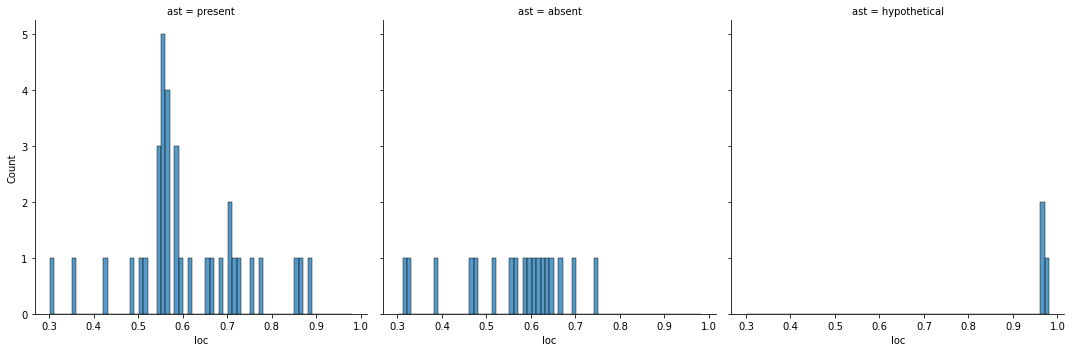

signing this document


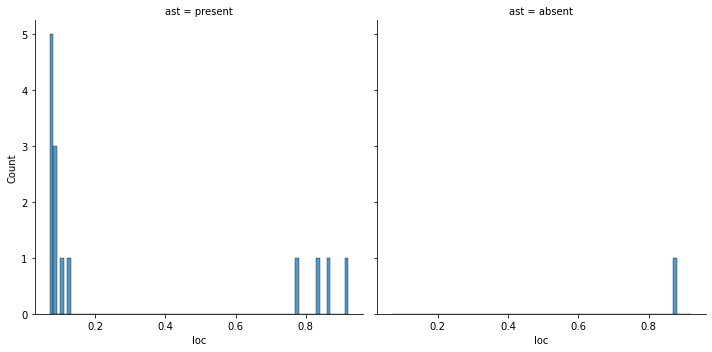

respiratory


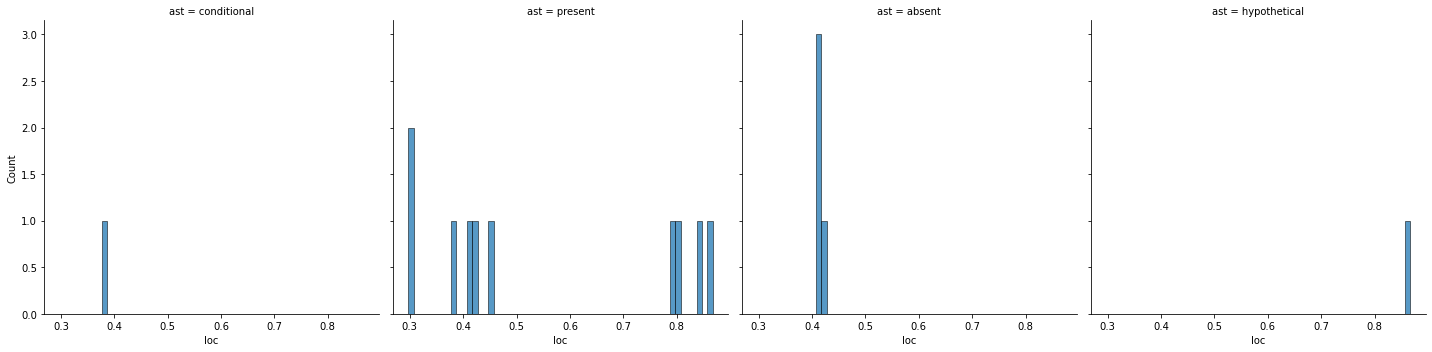

indications


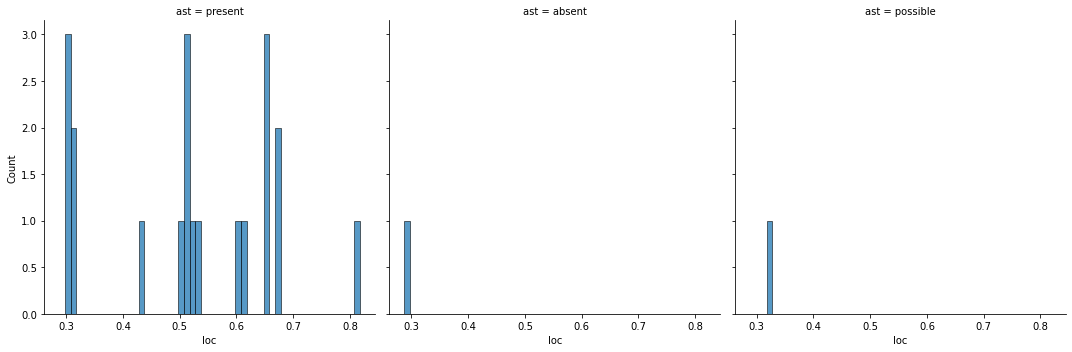

followup


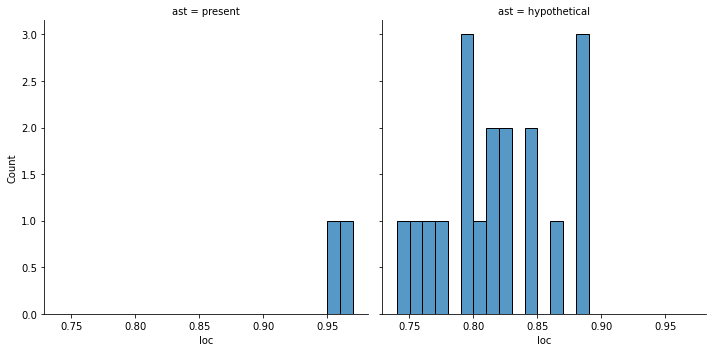

past history


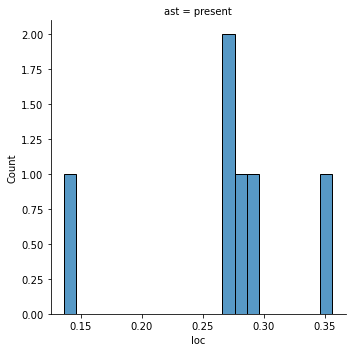

In [618]:
for s in common_sections:
    if s not in df.sections.values:
        continue
    sns.displot(df.loc[df['sections']==s], x='loc', binwidth=.01, col='ast')
    print(s)
    plt.show()

medications


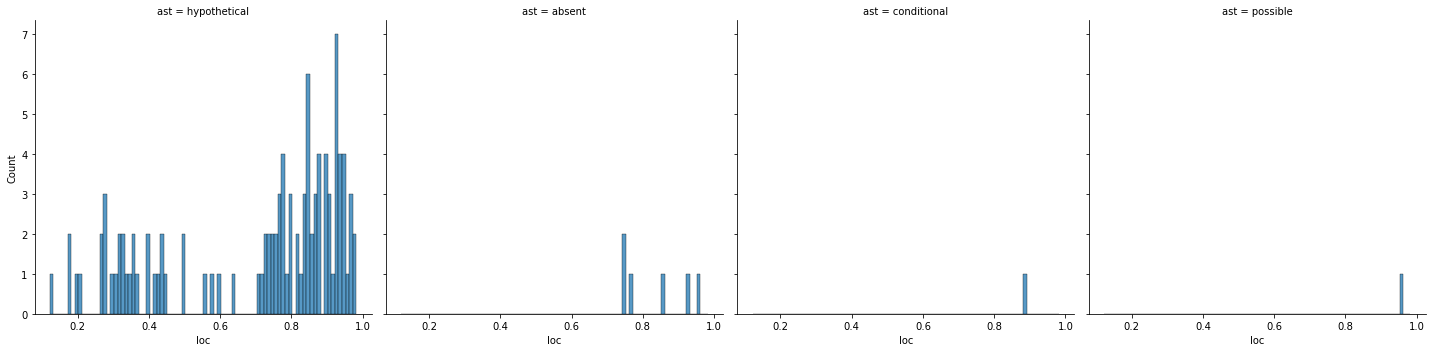

diagnoses


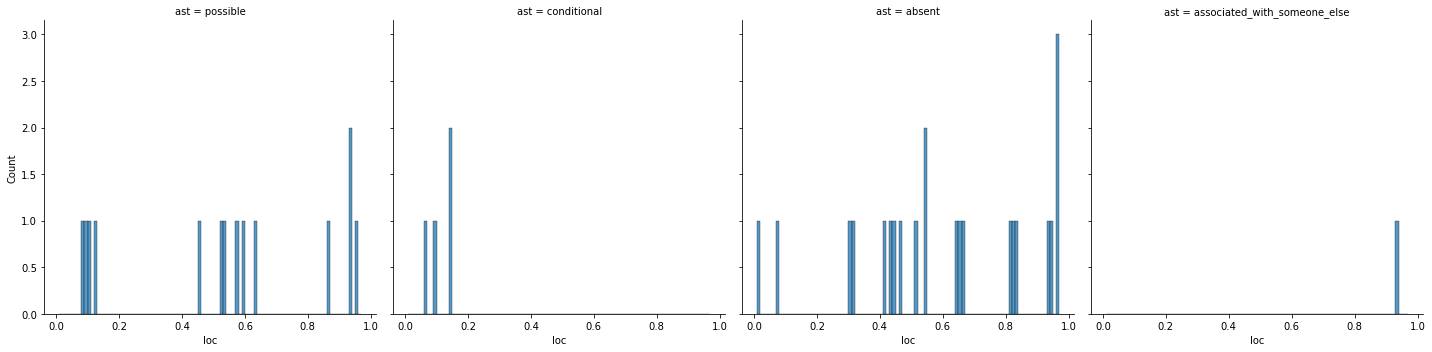

hospital course


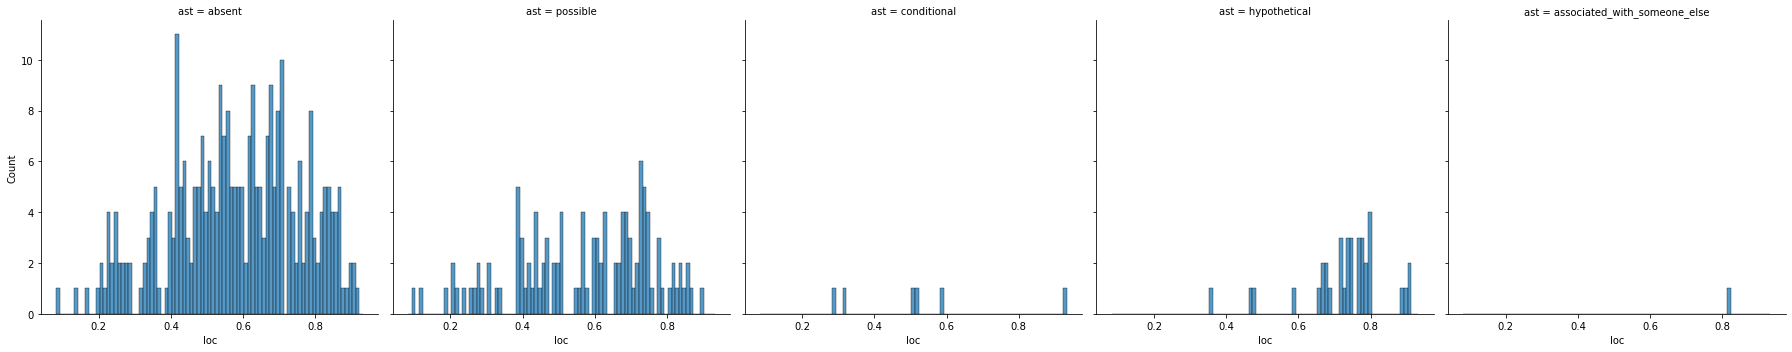

present illness


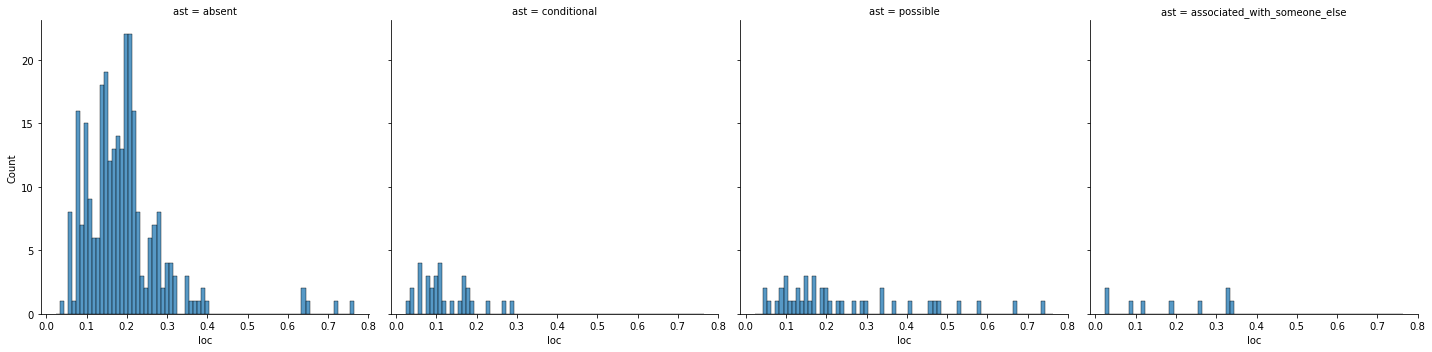

past medical history


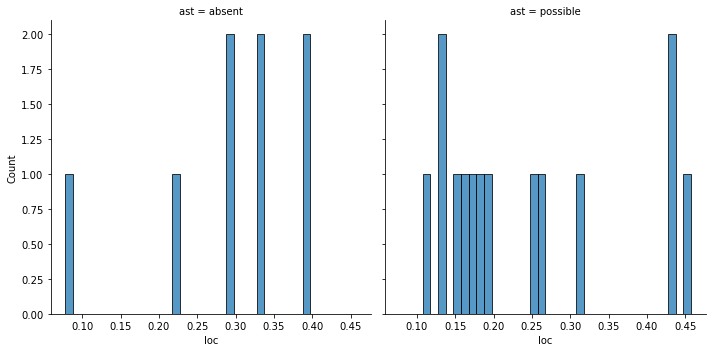

allergies


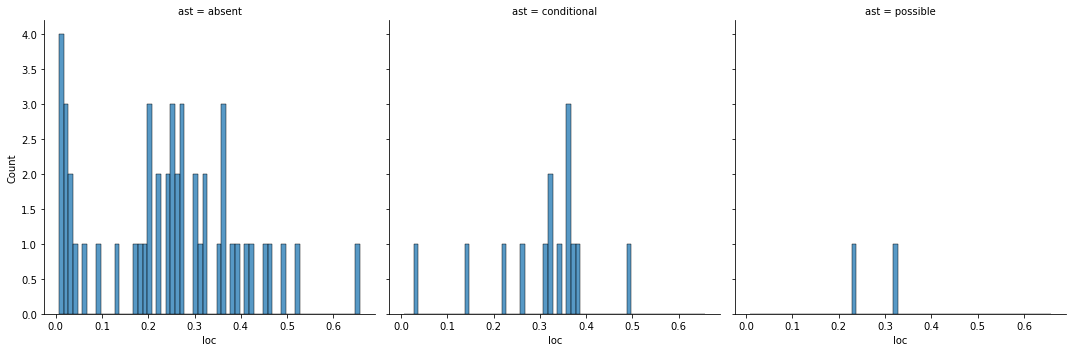

physical examination


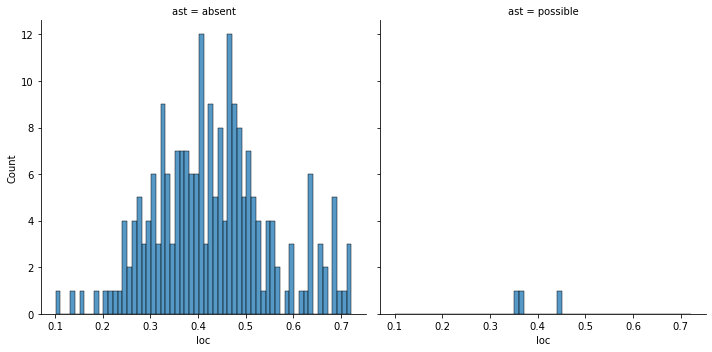

disposition


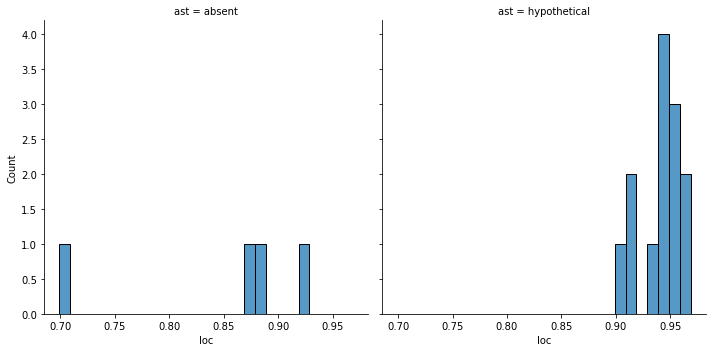

abdomen


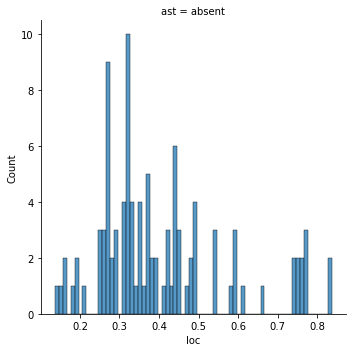

labs


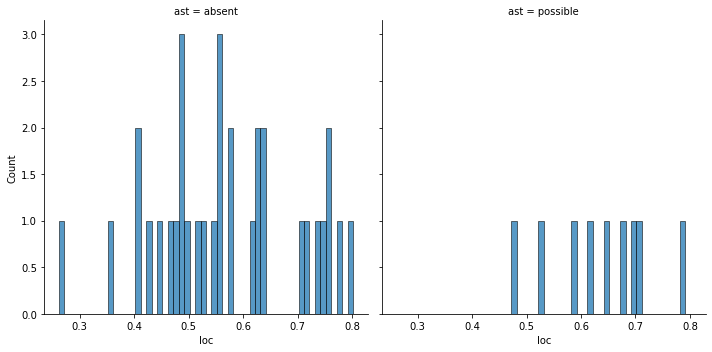

family history


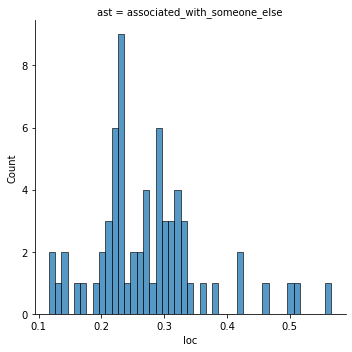

discharge instructions


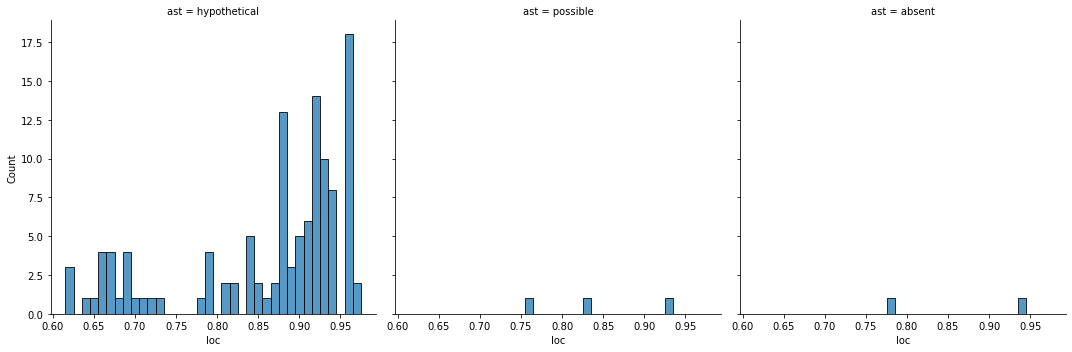

lungs


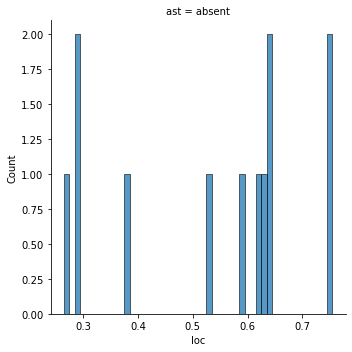

evaluation date


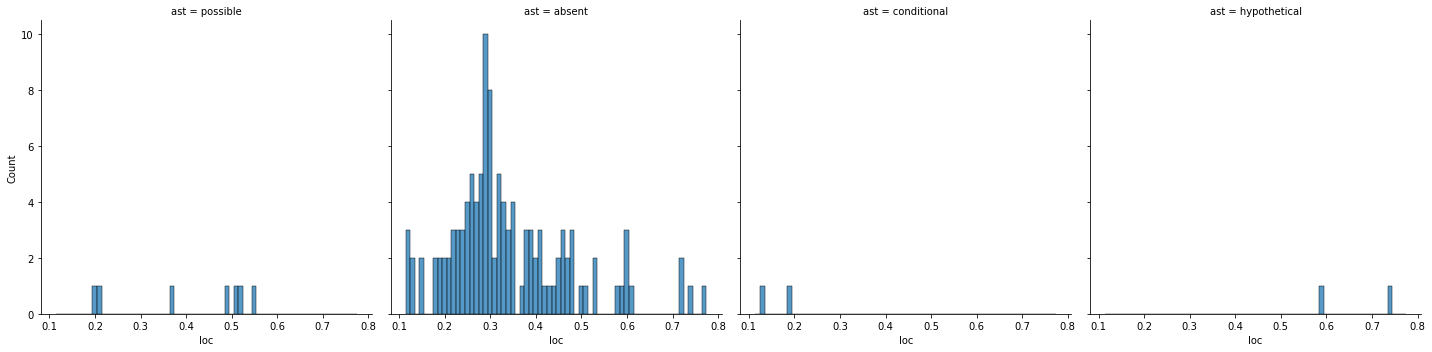

vitals


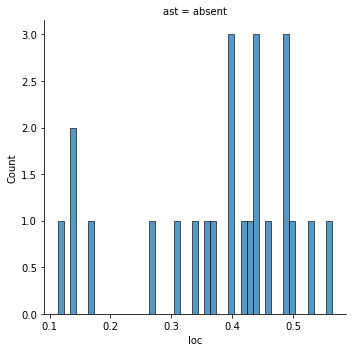

follow up


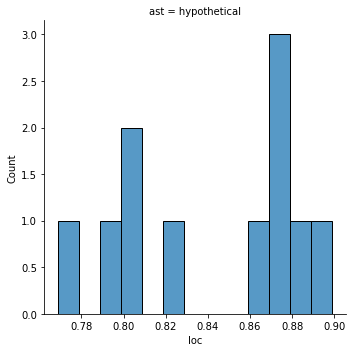

extremities


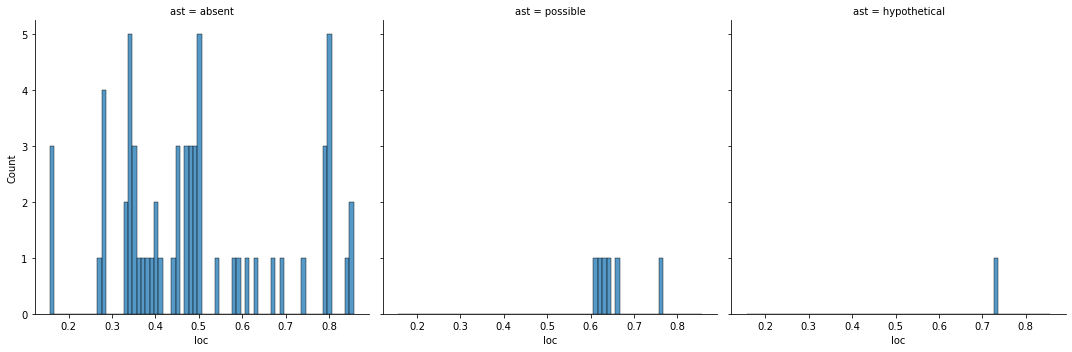

heent


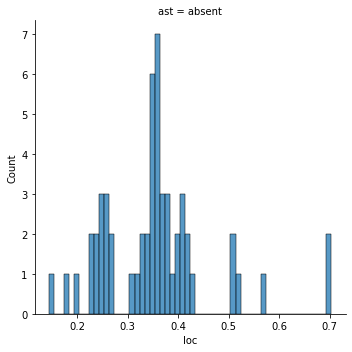

heart


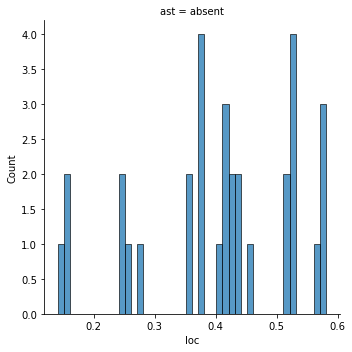

physical exam


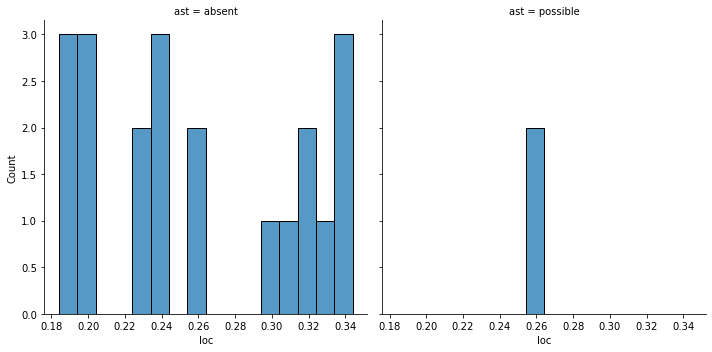

impression


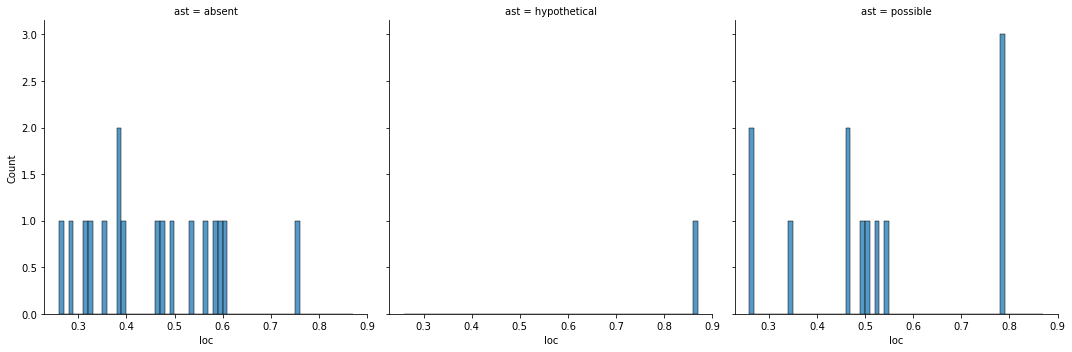

cardiovascular


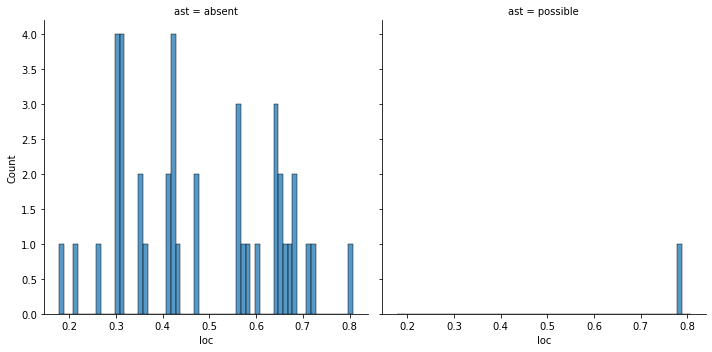

neck


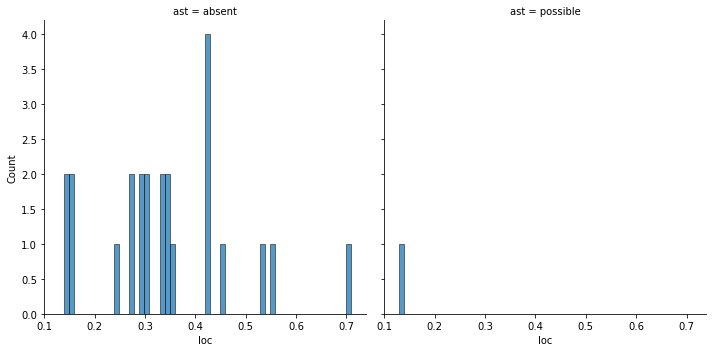

brief hospital course


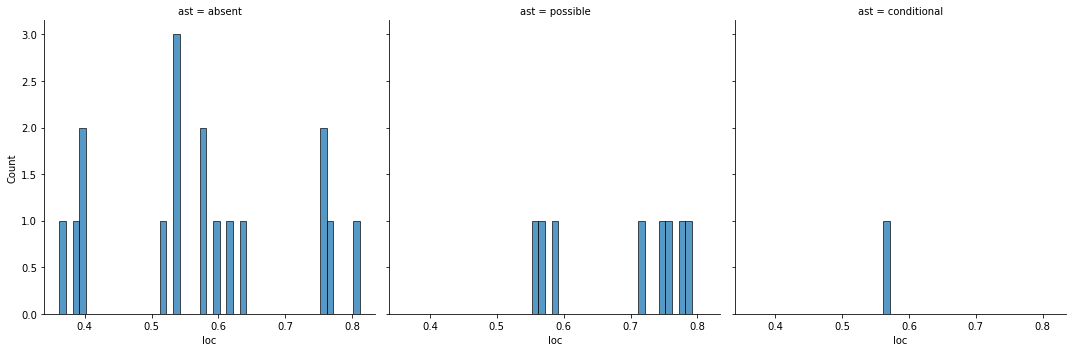

diet


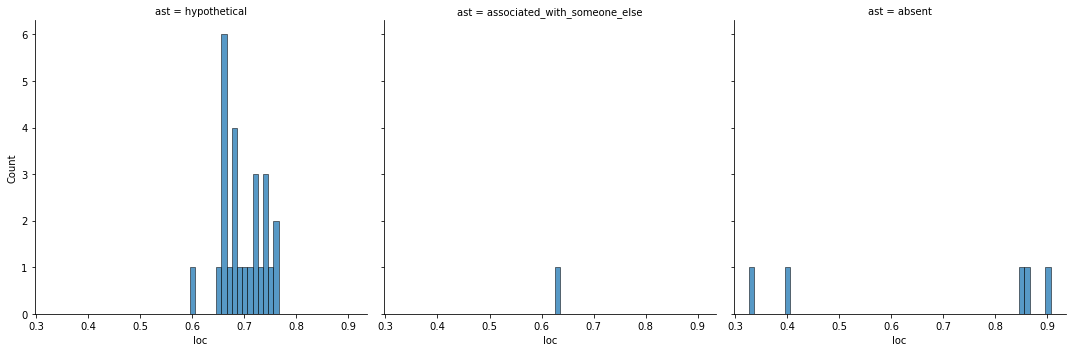

pertinent results


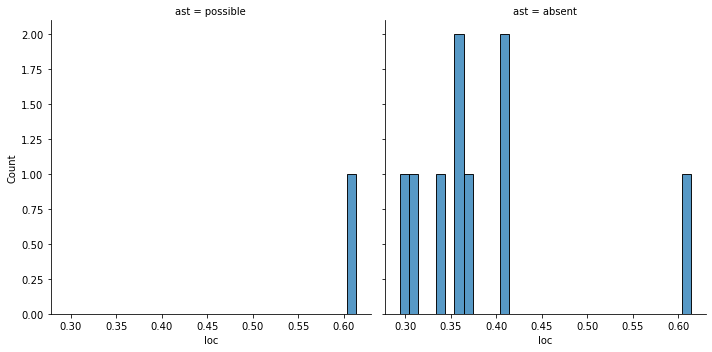

ext


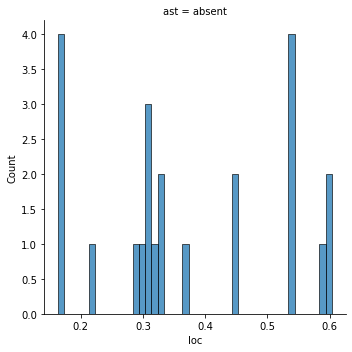

general


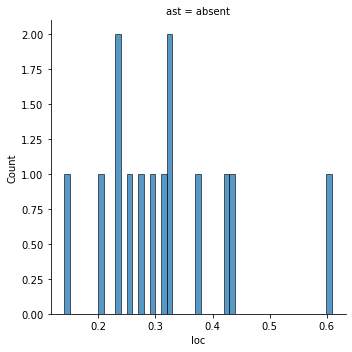

neurology


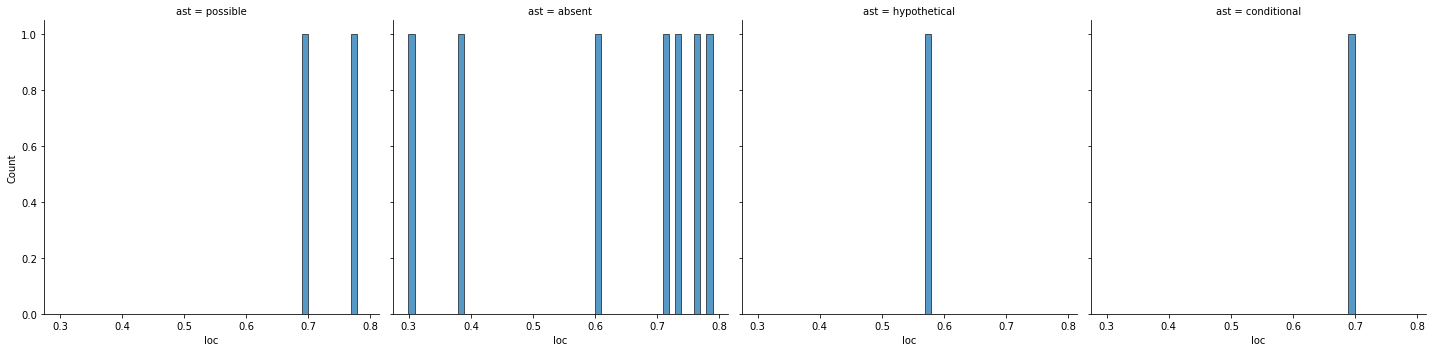

gen


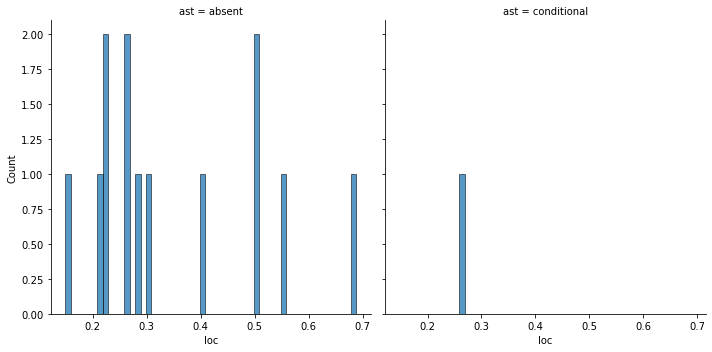

review of systems


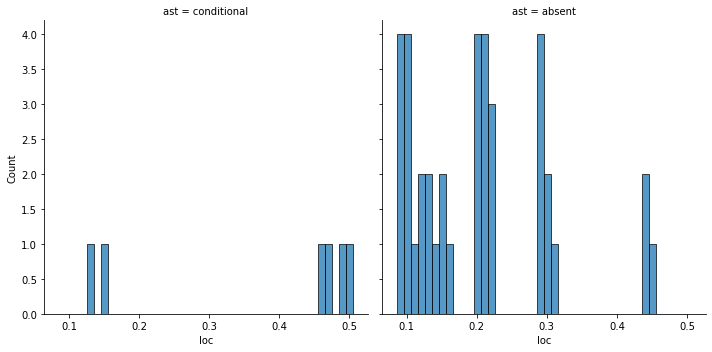

cv


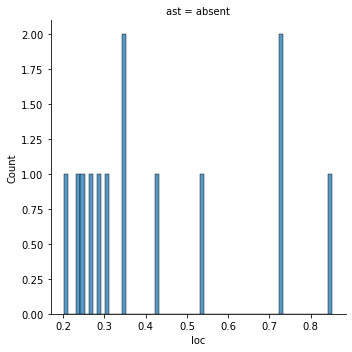

follow up and instructions to patient


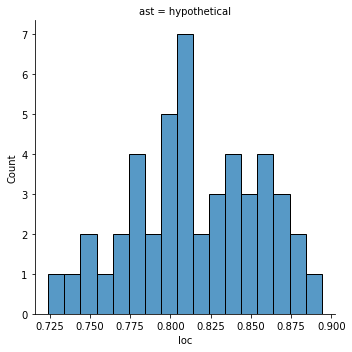

gastrointestinal


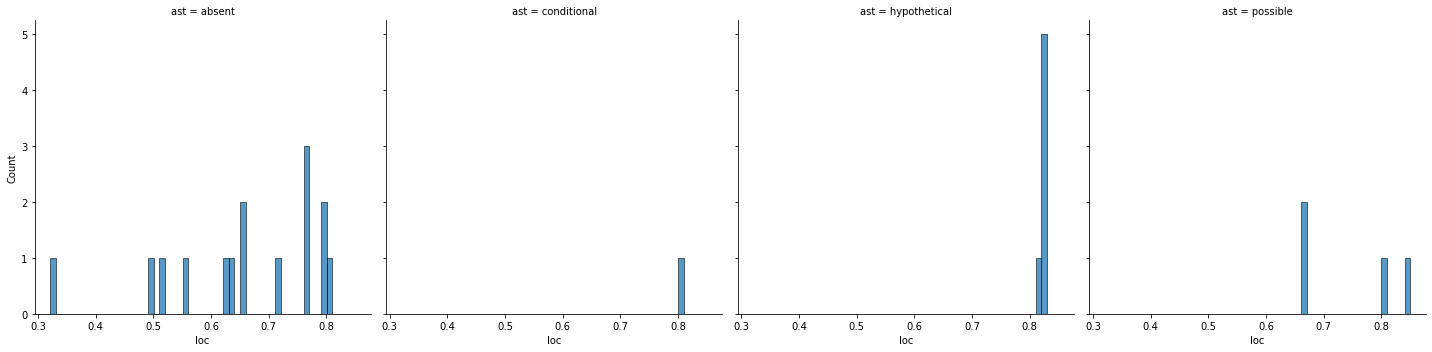

skin


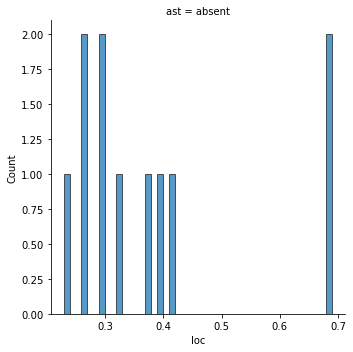

assessment and plan


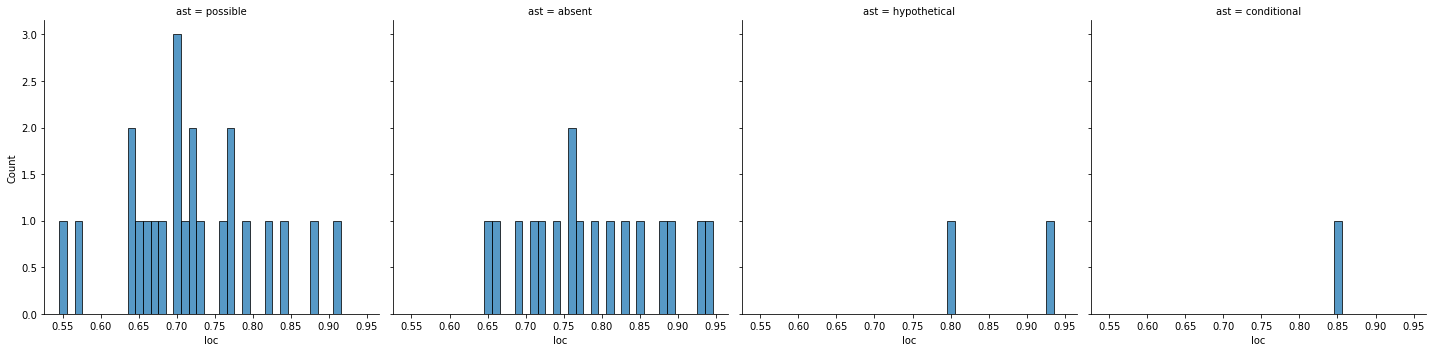

reason for admission


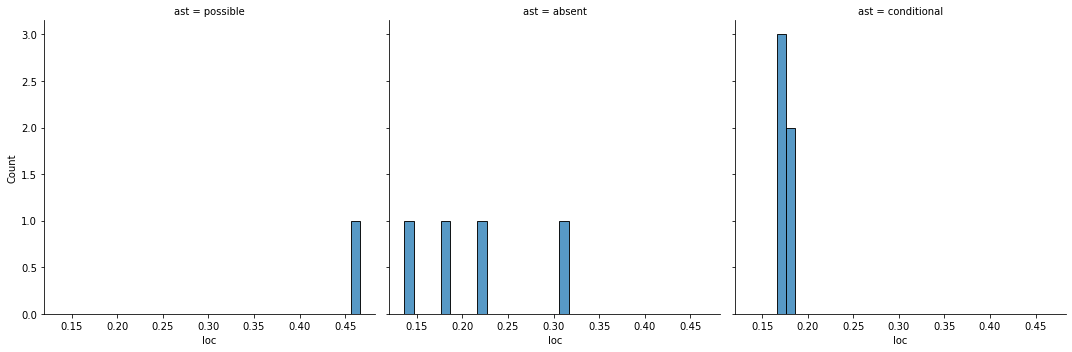

assessment/plan


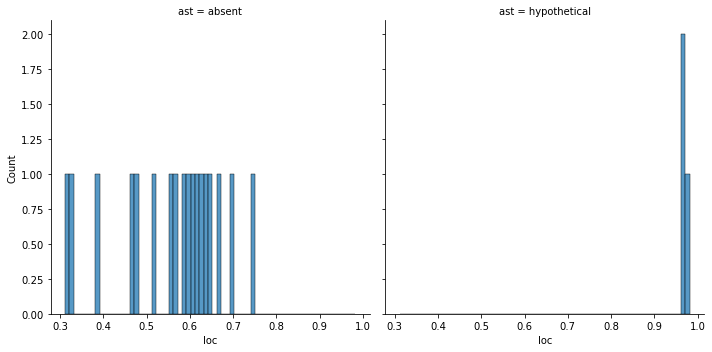

followup


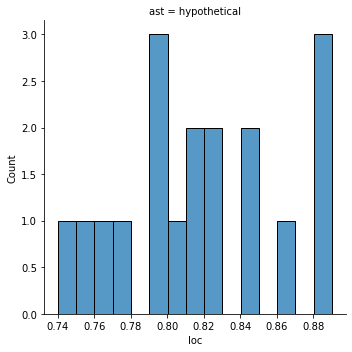

In [638]:
for s in common_sections:
    tmp = df.loc[(df['sections']==s) & (df['ast']!= 'present')]
    if len(tmp) < 10:
        continue
    sns.displot(tmp.loc[tmp['sections']==s], x='loc', binwidth=.01, col='ast')
    print(s)
    plt.show()